<h1>Geocoding Notebook - Ghana<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span></li><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-geoboundaries-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-geoboundaries-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to geoboundaries Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-FEWS-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-FEWS-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to FEWS Adm 2</a></span></li></ul></li></ul></li><li><span><a href="#Match-to-locations-from-alternative-sources-based-on-facility-name" data-toc-modified-id="Match-to-locations-from-alternative-sources-based-on-facility-name-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Match to locations from alternative sources based on facility name</a></span><ul class="toc-item"><li><span><a href="#Health-Sites-IO" data-toc-modified-id="Health-Sites-IO-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Health Sites IO</a></span></li><li><span><a href="#RHINoVision-Master-Facility-List-Decision-Support-System" data-toc-modified-id="RHINoVision-Master-Facility-List-Decision-Support-System-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RHINoVision Master Facility List Decision Support System</a></span></li></ul></li><li><span><a href="#Geocoding-with-APIs" data-toc-modified-id="Geocoding-with-APIs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Geocoding with APIs</a></span><ul class="toc-item"><li><span><a href="#Facility-name-and-admin-3-names" data-toc-modified-id="Facility-name-and-admin-3-names-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Facility name and admin 3 names</a></span></li><li><span><a href="#Facility-name-and-admin-2-names" data-toc-modified-id="Facility-name-and-admin-2-names-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Facility name and admin 2 names</a></span></li><li><span><a href="#Admin-3-names" data-toc-modified-id="Admin-3-names-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Admin 3 names</a></span></li><li><span><a href="#Admin-3--and-admin-2-names" data-toc-modified-id="Admin-3--and-admin-2-names-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Admin 3  and admin 2 names</a></span></li></ul></li><li><span><a href="#Map-and-save-results" data-toc-modified-id="Map-and-save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Map and save results</a></span><ul class="toc-item"><li><span><a href="#Join-attributes-from-adminsitrative-polygons" data-toc-modified-id="Join-attributes-from-adminsitrative-polygons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Join attributes from adminsitrative polygons</a></span></li></ul></li></ul></div>

Version: January 27, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources for health POI data, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 2)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [523]:
import os, sys
import geopandas as gpd
import pandas as pd
from geopy.geocoders import GeoNames, Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
from thefuzz import fuzz
from thefuzz import process
import matplotlib.pyplot as plt
from string import ascii_uppercase
import contextily as ctx
from os.path import join
import numpy as np
from dotenv import load_dotenv, find_dotenv

In [524]:
def remove_words(data_frame, column_name, words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']):
    """ Remove words from strings in a specified column
    
    Args:
        data_frame: Pandas data frame
        column_name: Column name to remove words from
        words_to_remove: List of words

    Returns:
        Removes words in place

    """
    for word in words_to_remove:
        data_frame[column_name] = data_frame[column_name].str.replace(word, "")
    data_frame[column_name] = data_frame[column_name].str.strip()
        
def report_geocoding(records):
    """ Report value counts and % from geocoding_method column.
    
    Args:
        records: Pandas data frame

    Returns:
        Table with count stats 
    """
    table = records[['NAME', 'geocoding_method']].groupby('geocoding_method').count().rename(columns={'NAME':'count'})
    table.loc[:, "pct"] = table/(table['count'].sum())
    table = table.style.format({
        'pct': '{:,.1%}'.format,
    })
    return(table)

def match_name(name, list_names, min_score=0):
    """ Uses fuzzy matching between one string and a list of candidate names.
    
    Args:
        name: string
        list_names: list of candidate names to match
        min_score: minimum score allowed

    Returns:
        Returns name with the highest match, and match score
        If no match is higher than min score, returns "" and -1
    """
    # -1 score incase we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iterating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

def match_to_closest(row, gdf, column='ADMIN2'):
    """ Spatial join using closest distance algorithm.
    
    Args:
        row: row from geo data frame
        gdf: gdf with attributes to join
        column: attribute to join

    Returns:
        Returns specified attribute of closest feature
    """
    distances = [row.geometry.distance(pol) for pol in gdf.geometry]
    min_id = np.argmin(distances)
    closest = gdf.iloc[min_id]
    return closest[column]

def run_geocoding(idx, row, master_table, admin_area, components, country_code):
    """
    Geocoding workflow to be applied to each row in a dataset
    
    Args:
        idx: index
        row: row with index and names to geocode
        master_table: master table to store results
        admin_area: gdf of admin area to ensure result falls within
        components: list of names of attributes to use in query
        country_code: two letter iso code
    
    Returns:
        Stores geocoding results in master_table object
    """
    admin_bounds = admin_area.bounds
    bb = [(admin_bounds.iloc[0].miny, admin_bounds.iloc[0].minx), (admin_bounds.iloc[0].maxy, admin_bounds.iloc[0].maxx)]
    method = ' and '.join(components)
    items = [row[item] for item in components]
    query = ', '.join(items)
    
    geocoding_result = None
    geocoding_method = "None"
    # Try Geocoding with OSM
    try:
        res = geolocator_osm.geocode(query, country_codes=country_code)
        # if within admin
        if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
            geocoding_result = res
            geocoding_method = f"{method} query OSM"
        else:
            raise Exception("OSM point not valid or not within polygon")
    except:
        # Try Geocoding with Bing Maps
        try:
            res = geolocator_bing.geocode(query)
            # if within admin
            if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                geocoding_result = res
                geocoding_method = f"{method} query Bing"
            else:
                raise Exception("Bing point not valid or not within polygon")
        except:
            # Try Geocoding with Google
            try:
                res = geolocator_google.geocode(query = query, region = country_code, bounds = bb)
                if res:
                    # if within admin
                    if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                        geocoding_result = res
                        geocoding_method = f"{method} query Google"
            except:
                raise Exception("Google point not valid or not within polygon")
    
    master_table.loc[idx, "geocoding_method"] = geocoding_method
    if geocoding_result:
        master_table.loc[idx, "longitude"] = res.longitude
        master_table.loc[idx, "latitude"] = res.latitude

In [525]:
iso3 = "GHA"
country = "Ghana"
input_dir = "/home/public/Data/PROJECTS/Health" 
output_dir = join(input_dir, "output")
# if not os.path.exists(out_folder):
#     os.mkdir(out_folder)

# Prepare and match admin boundary data 

In [526]:
# only up to Admin 2 exists for Ghana
#geob4 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM4/geoBoundaries-{iso3}-ADM4.geojson")
#geob3 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM3/geoBoundaries-{iso3}-ADM3.geojson")
geob2 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM2/geoBoundaries-{iso3}-ADM2.geojson")
geob1 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM1/geoBoundaries-{iso3}-ADM1.geojson")
#fews2 = gpd.read_file(join(input_dir, 'FEWS', 'SLE', 'SL_Admin2_2017.shp'))

Text(0.5, 1.0, '16 ADM1 boundaries')

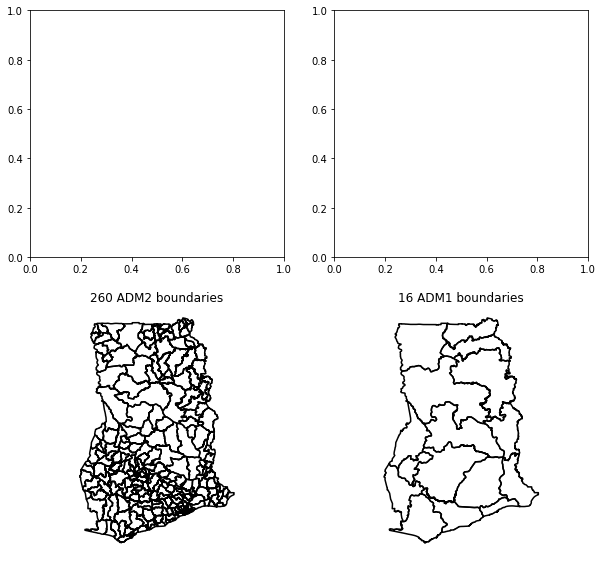

In [527]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
# geob4.boundary.plot(ax=ax[0, 0], color='black', linewidth=0.5).set_axis_off()
# ax[0, 0].set_title(f'{len(geob4)} ADM4 boundaries')
# geob3.boundary.plot(ax=ax[0, 1], color='black', linewidth=1).set_axis_off()
# ax[0, 1].set_title(f'{len(geob3)} ADM3 boundaries')
geob2.boundary.plot(ax=ax[1, 0], color='black').set_axis_off()
ax[1, 0].set_title(f'{len(geob2)} ADM2 boundaries')
geob1.boundary.plot(ax=ax[1, 1], color='black').set_axis_off()
ax[1, 1].set_title(f'{len(geob1)} ADM1 boundaries')
# plt.axis('off')

In [528]:
master_table = pd.read_csv(os.path.join(input_dir, "tom_formatted", "hierarchy", "tom_edited_ghana_collapsed.csv"), encoding='utf-8')

In [529]:
master_table.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5
0,Eastern,Abuakwa North,Kukurantumi,Esther Twum Maternity Home,Esther Twum Maternity Home
1,Eastern,Abuakwa North,Kukurantumi,Kukurantumi Apotosu,Kukurantumi Apotosu


In [530]:
len(master_table)

10564

In [531]:
print(f"Unique Level 2: {len(master_table.orgunitlevel2.unique())}")
print(f"Unique Level 3: {len(master_table.orgunitlevel3.unique())}")
print(f"Unique Level 4: {len(master_table.orgunitlevel4.unique())}")
print(f"Unique Level 5: {len(master_table.orgunitlevel5.unique())}")

Unique Level 2: 49
Unique Level 3: 482
Unique Level 4: 2487
Unique Level 5: 9060


In [532]:
print(f"Unique Geoboundaries Adm 1: {len(geob1)}")
print(f"Unique Geoboundaries Adm 2: {len(geob2)}")
#print(f"Unique Geoboundaries Adm 3: {len(geob3)}")
#print(f"Unique Geoboundaries Adm 4: {len(geob4)}")

Unique Geoboundaries Adm 1: 16
Unique Geoboundaries Adm 2: 260


## Match health list admin names to shapefile admin names
### Match orgunitlevel3 to geoboundaries Adm 2
Try using fuzzy matching  

In [533]:
level3_list = list(master_table.orgunitlevel3.unique())
level3_list.sort()
geob2_list = list(geob2.shapeName)
geob2_list.sort()

Print names one at a time for both datasets one letter at a time, and manually inspect

In [534]:
for letter in ascii_uppercase:
    level3_sublist = [name for name in level3_list if name[0]==letter]
    geob2_sublist = [name for name in geob2_list if name[0]==letter]

    if len(level3_sublist)>0:
        print("Master list level 3")
        print("\t"+str(level3_sublist))
    if len(geob2_sublist) >0:
        print("Geoboundaries adm2")
        print("\t"+str(geob2_sublist))
        
    print("\n")

Master list level 3
	['Abaam', 'Abamkrom', 'Abenase', 'Abenehease', 'Abetifi', 'Abiriw', 'Ablekuma Central', 'Ablekuma North', 'Ablekuma West', 'Aboabo', 'Abomasarefo', 'Abomosu', 'Abourso', 'Abuakwa North', 'Abuakwa South', 'Abura-Asebu-Kwamankese', 'Aburi', 'Accra Metro', 'Achiase', 'Ada East', 'Ada West', 'Adaklu', 'Adansi Akrofuom', 'Adansi Asokwa', 'Adansi North', 'Adansi South', 'Adawso', 'Adeiso', 'Adentan', 'Adjena Gyakiti', 'Adoagyiri', 'Aduasa', 'Adukrom', 'Adweso', 'Afadjato South', 'Afigya Kwabre North', 'Afigya Kwabre South', 'Afosu', 'Agavenya', 'Agogo (Eastern)', 'Agona East', 'Agona West', 'Agormanya', 'Agortime-Ziope', 'Agyata', 'Ahafo Ano North', 'Ahafo Ano South East', 'Ahafo Ano South West', 'Ahanta West', 'Ahomahomasu', 'Ajumako-Enyan-Essiam', 'Akanteng', 'Akateng', 'Akatsi North', 'Akatsi South', 'Akenkausu', 'Akim Swedru', 'Akoase', 'Akokoaso', 'Akorabo', 'Akosombo', 'Akote', 'Akrofufu', 'Akropong', 'Akropong (Eastern)', 'Akroso', 'Akuse', 'Akwadum', 'Akwamufie A

Manually adjust spellings of master health list to create more matches.

In [535]:
master_table.loc[:, "orgunitlevel3_edit"] = master_table.orgunitlevel3

In [536]:
# # master_table.loc[master_table.orgunitlevel4 == "Bo City", "orgunitlevel4_edit"] = "Bo Town"
# master_table.loc[master_table.orgunitlevel4 == "Central 1 Zone", "orgunitlevel4_edit"] = "Central I"
# master_table.loc[master_table.orgunitlevel4 == "Central 2 Zone", "orgunitlevel4_edit"] = "Central II"
# master_table.loc[master_table.orgunitlevel4 == "East 1 Zone", "orgunitlevel4_edit"] = "East I"
# master_table.loc[master_table.orgunitlevel4 == "East 2 Zone", "orgunitlevel4_edit"] = "East II"
# master_table.loc[master_table.orgunitlevel4 == "East 3 Zone", "orgunitlevel4_edit"] = "East III"
# master_table.loc[master_table.orgunitlevel4 == "West 1 Zone", "orgunitlevel4_edit"] = "West I"
# master_table.loc[master_table.orgunitlevel4 == "West 2 Zone", "orgunitlevel4_edit"] = "West II"
# master_table.loc[master_table.orgunitlevel4 == "West 3 Zone", "orgunitlevel4_edit"] = "West III"
# master_table.loc[master_table.orgunitlevel4 == "Bagbwe", "orgunitlevel4_edit"] = "Bagbwe(Bagbe)"

Remove key words that confuse matching algorithm

In [537]:
remove_words(master_table, "orgunitlevel3_edit", ['Town', 'City', 'Urban', 'Zone', 'Municipal'])
remove_words(geob2, "shapeName", ['Town', 'City', 'Urban', 'Zone', 'Municipal'])

In [538]:
# level4_list = list(master_table.orgunitlevel4.unique())
level3_list = list(master_table.orgunitlevel3_edit.unique())
level3_list.sort()
geob2_list = list(geob2.shapeName)
geob2_list.sort()

In [539]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over orgunitlevel4_edit list
for name in level3_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob2_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level2" : name})
    dict_.update({"name_geob2" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm2 = pd.DataFrame(dict_list)
table_adm2_matches = table_adm2[table_adm2.score > 70].copy()

In [540]:
matches_pct = (len(table_adm2_matches) / len(level3_list))
'{:.2f}%'.format(matches_pct*100)

'56.85%'

In [541]:
# could save this list for someone to confirm matches manually
# for now take input noting which ones should be dropped based on quick inspection
table_adm2_matches.loc[table_adm2_matches.score<=80]

,name_level2,name_geob2,score
30,Adoagyiri,Nsawam Adoagyiri,72
101,Asante Mampong,Asokore Mampong,76
107,Asiakwa,Asokwa,77
124,Asuokaw,Asokwa,77
157,Bepong,Bongo,73
158,Berekum,Berekum East,74
170,Boadua,Banda,73
174,Bolgatanga East,Bolgatanga,80
179,Boti,Bodi,75
180,Brekumanso,Berekum East,73


In [542]:
for idx, row in table_adm2_matches.loc[table_adm2_matches.score<=80].iterrows():
    print(row)
    print('\n')
    #drop_input = input("Drop? If no, leave blank: ")
    if len(drop_input)>0:
        table_adm2_matches.drop(idx, axis=0, inplace=True)

name_level2           Adoagyiri
name_geob2     Nsawam Adoagyiri
score                        72
Name: 30, dtype: object


name_level2     Asante Mampong
name_geob2     Asokore Mampong
score                       76
Name: 101, dtype: object


name_level2    Asiakwa
name_geob2      Asokwa
score               77
Name: 107, dtype: object


name_level2    Asuokaw
name_geob2      Asokwa
score               77
Name: 124, dtype: object


name_level2    Bepong
name_geob2      Bongo
score              73
Name: 157, dtype: object


name_level2         Berekum
name_geob2     Berekum East
score                    74
Name: 158, dtype: object


name_level2    Boadua
name_geob2      Banda
score              73
Name: 170, dtype: object


name_level2    Bolgatanga East
name_geob2          Bolgatanga
score                       80
Name: 174, dtype: object


name_level2    Boti
name_geob2     Bodi
score            75
Name: 179, dtype: object


name_level2      Brekumanso
name_geob2     Berekum East
score 

In [543]:
matches_pct = (len(table_adm2_matches) / len(level3_list))
'{:.2f}%'.format(matches_pct*100)

'56.85%'

### Match orgunitlevel2 to geo Adm 1

In [544]:
master_table.loc[:, "orgunitlevel2_edit"] = master_table.orgunitlevel2

In [545]:
# remove_words(geob2, "admin2Name", [" City Council", " District Council", " Municipal Council"])
remove_words(master_table, "orgunitlevel2_edit", [" District"])
remove_words(geob1, "shapeName", [" City Council", " District Council", " Municipal Council", "Region"])

In [546]:
level2_list = list(master_table.orgunitlevel2_edit.unique())
level2_list.sort()
geob1_list = list(geob1.shapeName)
geob1_list.sort()
# fews2_list = list(fews2.ADMIN2)
# fews2_list.sort()

Print names one at a time for both datasets one letter at a time, and manually inspect

In [547]:
for letter in ascii_uppercase:
    level2_sublist = [name for name in level2_list if name[0]==letter]
    geob1_sublist = [name for name in geob1_list if name[0]==letter]
    #fews2_sublist = [name for name in fews2_list if name[0]==letter]
    if len(level2_sublist)>0:
        print("Master list level 2")
        print("\t"+str(level2_sublist))
    if len(geob1_sublist) > 0:
        print("Geoboundaries adm1")
        print("\t"+str(geob1_sublist))
#     if len(fews2_sublist) > 0:
#         print("FEWS adm2")
#         print("\t"+str(fews2_sublist))
    print("\n")

Master list level 2
	['Abuakwa North', 'Abuakwa South', 'Achiase', 'Ahafo', 'Akwapim North', 'Akwapim South', 'Akyemansa', 'Asene Manso Akroso', 'Ashanti', 'Asuogyaman', 'Atiwa East', 'Atiwa West', 'Ayensuano']
Geoboundaries adm1
	['Ahafo', 'Ashanti']


Master list level 2
	['Birim Central', 'Birim North', 'Birim South', 'Bono', 'Bono East']
Geoboundaries adm1
	['Bono', 'Bono East']


Master list level 2
	['Central']
Geoboundaries adm1
	['Central']


Master list level 2
	['Denkyembour']


Master list level 2
	['Eastern']
Geoboundaries adm1
	['Eastern']


Master list level 2
	['Fanteakwa North', 'Fanteakwa South']


Master list level 2
	['Greater Accra']
Geoboundaries adm1
	['Greater Accra']








Master list level 2
	['Kwaebibirem', 'Kwahu Afram Plains North', 'Kwahu Afram Plains South', 'Kwahu East', 'Kwahu South', 'Kwahu West']


Master list level 2
	['Lower Manya-Krobo']




Master list level 2
	['New Juaben North', 'New Juaben South', 'North East', 'Northern', 'Nsawam-Adoagyiri']

In [548]:
# List for dicts for easy dataframe creation
dict_list = []

for name in level2_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob1_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level1" : name})
    dict_.update({"name_geob1" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm1 = pd.DataFrame(dict_list)
table_adm1_matches = table_adm1[table_adm1.score > 75]

In [549]:
matches_pct = (len(table_adm1_matches) / len(level2_list))
'{:.2f}%'.format(matches_pct*100)

'34.69%'

Loop through each row in master table, and add new attribute names (adm2 and adm1), if the names produced matches in the lookup tables

In [550]:
master_table_copy = master_table.copy()

In [551]:
master_table_copy

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel3_edit,orgunitlevel2_edit
0,Eastern,Abuakwa North,Kukurantumi,Esther Twum Maternity Home,Esther Twum Maternity Home,Kukurantumi,Abuakwa North
1,Eastern,Abuakwa North,Kukurantumi,Kukurantumi Apotosu,Kukurantumi Apotosu,Kukurantumi,Abuakwa North
2,Eastern,Abuakwa North,Kukurantumi,Kukurantumi,Kukurantumi,Kukurantumi,Abuakwa North
3,Eastern,Abuakwa North,Kukurantumi,Sokode Juaso,Sokode Juaso,Kukurantumi,Abuakwa North
4,Eastern,Abuakwa North,Kukurantumi,The Community Hospital (Kukurantumi),The Community Hospital (Kukurantumi),Kukurantumi,Abuakwa North
...,...,...,...,...,...,...,...
10559,Ghana,Western North,Suaman,Karlo,Karlo,Suaman,Western North
10560,Ghana,Western North,Suaman,Karlo,Kwabenakrom,Suaman,Western North
10561,Ghana,Western North,Suaman,Karlo,Sui-Ano,Suaman,Western North
10562,Ghana,Western North,Suaman,Kwasuo,Kwassuo,Suaman,Western North


In [552]:
for idx, row in master_table_copy.iterrows():
    
    if row.orgunitlevel3_edit in list(table_adm2_matches.name_level2):
        
        match = table_adm2_matches.loc[table_adm2_matches.name_level2==row.orgunitlevel3_edit, "name_geob2"].iloc[0]
        master_table_copy.loc[idx, 'adm2'] = match
        
    if row.orgunitlevel2_edit in list(table_adm1_matches.name_level1):
        
        match = table_adm1_matches.loc[table_adm1_matches.name_level1==row.orgunitlevel2_edit, "name_geob1"].iloc[0]
        master_table_copy.loc[idx, 'adm1'] = match

In [553]:
master_table_copy.adm2.isna().sum()

1355

In [554]:
master_table_copy.adm1.isna().sum()

1108

In [555]:
master_table_copy.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel3_edit,orgunitlevel2_edit,adm2,adm1
0,Eastern,Abuakwa North,Kukurantumi,Esther Twum Maternity Home,Esther Twum Maternity Home,Kukurantumi,Abuakwa North,NaN,NaN
1,Eastern,Abuakwa North,Kukurantumi,Kukurantumi Apotosu,Kukurantumi Apotosu,Kukurantumi,Abuakwa North,NaN,NaN


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.  
In QGIS, I created centroids from the ways then merged it with the points.

In [556]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", "GHA", "merged_GHA_healthsites.shp"))

In [557]:
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()

In [558]:
nodes_io['name'] = nodes_io['name'].str.lower()

In [559]:
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']

In [560]:
records = master_table_copy.copy()
records['NAME'] = records['orgunitlevel5'].str.lower()

In [561]:
remove_words(nodes_io, 'name', words_to_remove)
remove_words(records, 'NAME', words_to_remove)

In [562]:
records['geocoding_method'] = "None"

In [563]:
for idx, row in tqdm(records.iterrows()):
    
    # Check if there is another entry with location
    match, score = match_name(row.NAME, list(nodes_io['name']), 75)
#     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)
    
    if score > 0:
        print(row.NAME, match)
        matching_row = nodes_io.loc[nodes_io['name']==match].copy()
        res = matching_row.iloc[0]
        
        geocoded=False
        if not pd.isna(row.adm2):
            adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
            if adm2.contains(res.geometry).values[0] == True:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 2"
                geocoded=True
        
        if (geocoded==False) and (not pd.isna(row.adm1)):
            adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy()
            if adm1.contains(res.geometry).values[0] == True:            
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 1"
                geocoded=True
                
        if geocoded==False:
            records.loc[idx, "longitude"] = res.geometry.x
            records.loc[idx, "latitude"] = res.geometry.y
            records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and without admin verification"

12it [00:00, 105.90it/s]

esther twum maternity home osu maternity home
anyinasin nyinahin
new tafo new tafo
reliance maternity home florence maternity home


68it [00:00, 100.87it/s]

kibi kibi
bomponso bomso
achiase achiase
lab labs


102it [00:00, 126.31it/s]

adawso adweso
akropong darpong
obosomase bodomase
tetteh quarshie memorial tetteh quarshie


138it [00:01, 135.35it/s]

ados maternity home osu maternity home
abaase daboase
nsakye nsuakyire


169it [00:01, 132.40it/s]

anyinase aiyinase
odumase bodomase
brenase breast
chia charia
bontodiase abotoase
holy horniel maternity home florence maternity home


209it [00:01, 109.36it/s]

asene baseline
asene baseline
emmauel maternity. home osu maternity home
st theresa st. theresia
eshiem esidem


238it [00:01, 117.50it/s]

odumase bodomase
adjena adenta
adjena adenta
aboasa daboase
osiabura abura


273it [00:02, 124.75it/s]

boso aboso
boso aboso
line medical linfam medical
mampong mampong


310it [00:02, 144.07it/s]

new jejeti new jejeti
achiansa achiase


345it [00:02, 141.53it/s]

otoase abotoase
essam essiama
epl epcl
oda oda
oda oda


395it [00:02, 139.23it/s]

akoase daboase
okaikrom kwamikrom
oforikrom kofikrom
awisa sawia


410it [00:03, 127.91it/s]

luak maternity home osu maternity home
akwatia kpatia
st dominic st.dominic
boadua bodada
aweanso adweso


460it [00:03, 138.11it/s]

abourso aburaso
abaase daboase


494it [00:03, 146.71it/s]

nkankama nkwankwaa
akyease ayeduase
his grace maternity home zaclex maternity home


553it [00:04, 154.37it/s]

holy rosary holy rosary
abotanso aboso
atakora takoradi
kasanoma anoma


593it [00:04, 151.31it/s]

kpala sankpala
agyata agyakwa
asanyanso asanyansu
akwasiho fakwasi


626it [00:04, 129.60it/s]

ankoma anoma
oframase maternity home osu maternity home
the life care life  care
nteso suntreso
nkwatia kpatia
asakraka asakraka


641it [00:04, 110.05it/s]

asakraka town asakraka
bepong jephong
amartey samartex
atibie atibie
mpraeso general mamobi general


688it [00:05, 130.14it/s]

adawso adweso
asubone labone
nya akoma maternity home nyameadom maternity home
kenop care kenop care


720it [00:05, 127.37it/s]

agyakwa agyakwa
abanse daboase
akuse akuse


747it [00:05, 118.66it/s]

adome adidome
asitey site
kpong kpongka
kpong-zongo konongo
atua atua
atua atua


774it [00:05, 112.35it/s]

lydia maternity home edith's maternity home
mampong mampong
faoman oman
standard specialist tizaa specialist


803it [00:06, 96.57it/s] 

asaman amasaman
abotanso aboso
adweso adweso
adweso adweso
dr. asomani dr asomani
koforidua poly school koforidua poly
providence providence


832it [00:06, 96.85it/s] 

koforidua poly koforidua poly
oman oman
eastern regional eastern regional
tanoso tanoso
cosmos/damien cosmas- damien
koforidua koforidua


855it [00:06, 99.96it/s]

koforidua sda koforidua
newlands medical newlands medical
akyinaso anyinasuso
chinto chirano


878it [00:06, 105.34it/s]

lantei lane
nacolis medical nyaho medical
philta medical raphal medical
abonse labone


930it [00:07, 127.11it/s]

aboma anoma
lakpa lapaz
providence medical providence medical
suhum district savelugu district
asarekrom asarekrom chps


944it [00:07, 127.34it/s]

okanta okanta
ben dora maternity home osu maternity home
frida memorial grace memorial
suhum suhum


984it [00:07, 105.04it/s]

sawa sawia
alidor maternity home osu maternity home
asesewa asesewa
asesewa asesewa
bormase bodomase
daales maternity home zaclex maternity home


1016it [00:08, 98.67it/s] 

agyirkwa agyakwa
kumikrom kwamikrom
adeiso adeiso


1074it [00:08, 140.88it/s]

abaase daboase
bronoso bogoso
anum-asaman amasaman


1108it [00:08, 130.33it/s]

akpo vakpo
wurapong dawurampong


1148it [00:09, 118.17it/s]

somanya poly dansoman poly
unity maternity home osu maternity home
akrodie akrodie
mensahkrom  compound nsowakrom chps compound


1163it [00:09, 100.27it/s]

pomaakrom  compound nsowakrom chps compound
abotanso aboso
agyei mensah maternity home agyei-mensah memorial home


1176it [00:09, 76.31it/s] 

cross care cross care
goaso municipal goaso municipal
ahmadiyya muslim ahmadiyya muslim
bediako bedita


1186it [00:09, 55.05it/s]

life care life  care
asarekrom asarekrom chps
asunafo south district kintampo south district


1215it [00:10, 74.88it/s]

siana santa
star of hope star of hope
achiase achiase


1244it [00:10, 81.73it/s]

cross care cross care
esther maternity home edith's maternity home
akotosu kotoku


1276it [00:10, 92.65it/s]

apebuoso aboso
apenemadi  compound apenamadi chips compound
mankranho mankranso


1295it [00:11, 78.20it/s]

subreso suntreso
bomaa district bole district


1315it [00:11, 88.34it/s]

tanoano  compound dantano chips compound
bechem bechem
mansin  compound mansion chips compound
st. joseph st. joseph's


1334it [00:11, 60.59it/s]

adaa  compound adaa chps compound
ankaase  compound nkaseim chps compound
asuboe  compound asuboi chips compound
alata  compound holata chps compound


1359it [00:11, 71.10it/s]

wamase  compound mansie chips compound
anomabo anoma
st. louis st. lukes


1390it [00:12, 78.35it/s]

anhwiaso ahwiaso
fomena komenda


1425it [00:12, 91.62it/s]

fomena komenda
kramokrom kwamikrom
aburaso aburaso
amudurase samudure
fountain enclave fountain care


1482it [00:13, 97.62it/s]

ashan medical raphal medical
godcom maternity home osu maternity home


1497it [00:13, 79.40it/s]

mpobi mamprobi
mpobi mamprobi
bomso bomso


1510it [00:13, 75.06it/s]

jeloa maternity home osu maternity home
gladys maternity home osu maternity home
kodie akrodie


1521it [00:13, 59.11it/s]

anyinasuso anyinasuso
anyinasuso anyinasuso
achina achiase


1561it [00:14, 80.46it/s]

odumase bodomase
anane aya maternity home nyameadom maternity home


1575it [00:14, 86.77it/s]

st. edwards st. edward's
abesewa asesewa
nsuta nesta


1594it [00:14, 76.60it/s]

bonkwaso nkwaeso
mankranso mankranso
mankranso mankranso


1612it [00:15, 57.69it/s]

st. anns st. anthony's
achiase achiase
st. johns st. joseph's
hia shia


1628it [00:15, 56.40it/s]

abuakwaa abuakwa
abuakwaa abuakwa
fiankoma anoma


1635it [00:15, 44.28it/s]

fiankoma anoma
kofihwikrom kofikrom
krofrom kofikrom


1664it [00:15, 61.39it/s]

achiase achiase
st. martin's catholic st. martin's chemists
kantanka maternity home nyameadom maternity home


1688it [00:16, 67.42it/s]

abuoso aboso
aboaboso aboso
akropong darpong


1696it [00:16, 55.70it/s]

asarekrom asarekrom chps
mother of god mother of god


1729it [00:16, 67.40it/s]

onyame akwan maternity home nyameadom maternity home
dwease new town kpeve new town
kramokrom kwamikrom


1757it [00:17, 72.68it/s]

odumase bodomase
graham memorial grace memorial


1785it [00:17, 85.34it/s]

akutuase akuse
tanoah baptist medical baptist medical
adomfe adidome


1813it [00:17, 83.77it/s]

dampong darpong
juaso district jasikan district


1841it [00:18, 90.95it/s]

roses maternity home osu maternity home
koikrom kofikrom


1875it [00:18, 98.17it/s] 

nkwanta okanta
mampong mampong
mprim prime


1902it [00:18, 101.56it/s]

my paradise maternity home nyameadom maternity home
luhaki medical daks medical
owusuaa maternity home osu maternity home


1923it [00:19, 71.33it/s] 

d-line medline
providence providence
royal ho royal
garden city garden city


1951it [00:19, 75.00it/s]

roman catholic roman catholic
awurade adom maternity home nyameadom maternity home
hallmark medical all care medical


1960it [00:19, 56.87it/s]

kaase maternity home osu maternity home
maud's maternity home edith's maternity home
kumasi south kumasi south urban


1996it [00:19, 82.07it/s]

st. anne's st. anthony's
garry marvin memorial gary marvin memorial
maba mba


2006it [00:20, 64.79it/s]

samel samsel
aburaso aburaso
dufie memorial ami memorial


2024it [00:20, 59.80it/s]

trinity specialist trust specialist
jechi enchi
abotiaso aboso


2032it [00:20, 42.53it/s]

good news maternity home osu maternity home
kwanwoma anoma
kwanwoma anoma
anansu asanyansu


2050it [00:21, 46.48it/s]

erica maternity home edith's maternity home
kotokuom kotoku
victory maternity home osu maternity home
achiase achiase


2056it [00:21, 36.56it/s]

agogoso bogoso
nyinahin nyinahin
jaliat medical anglican medical


2071it [00:21, 44.60it/s]

sreso suntreso
abuakwa abuakwa
abuakwa  poly adabraka poly


2083it [00:21, 39.81it/s]

baptist medical , abuakwa baptist medical  nalerigu
madonna  services ghana  service
asakrakra asakraka


2102it [00:22, 43.96it/s]

frimpong boateng  medical frimpong boateng medical
toase abotoase
akropong darpong
akropong maternity home osu maternity home


2108it [00:22, 41.31it/s]

y care medical all care medical
mount sinai mount sinai
najet medical neptune medical


2113it [00:22, 32.46it/s]

achiase achiase
adankwame  compound adaa chps compound
asamang amasaman


2131it [00:23, 39.64it/s]

asamang amasaman
dabaa adabraka
ahwene memorial ahwenie memorial


2149it [00:23, 44.88it/s]

ahwiaa ahwiaso
bekwai municipal bekwai municipal
bodoma bodomase
adjamasu ahamasu


2169it [00:23, 57.89it/s]

asamang amasaman
ahmadiyya muslim ,  bekwai ahmadiyya muslim
akomaah memorial amoah memorial


2192it [00:24, 59.08it/s]

tenkwaamah maternity home nyameadom maternity home
adeito adeiso
adumasa  compound adaa chps compound


2206it [00:24, 48.61it/s]

duase ayeduase
richard fowle catholic richard fowler catholic
abosamso aboso
anyinase aiyinase
korchikrom kofikrom


2230it [00:24, 63.85it/s]

comfap maternity faith maternity
jachie achiase
pipie  compound chips compound


2259it [00:25, 69.38it/s]

abono aboso
ayush memorial amoah memorial
nkwanta okanta


2296it [00:25, 84.56it/s]

dorla maternity home osu maternity home
sanford sanford


2316it [00:25, 93.99it/s]

agape medical accra medical
isaap medical aniwaa medical
kwaso nkwaeso


2327it [00:25, 64.81it/s]

st. anthony anns st. anthony's
anyinasu east anyinasuso
anyinasu west anyinasuso


2336it [00:26, 50.63it/s]

babaso aburaso
abota abotoase
 


2355it [00:26, 56.40it/s]

nkwanta okanta
frante franeva


2410it [00:26, 83.20it/s]

new koforidua koforidua
atia kpatia
kumaning medical kamina medical


2431it [00:27, 78.52it/s]

atasamanso atasomanso
atasomanso atasomanso
mount zion mount sinai
asafo agyei asafo agyei


2440it [00:27, 66.78it/s]

champion divine champion divine
new cross new cross
prima medical port medical
adab sab maternity home osu maternity home


2471it [00:27, 76.15it/s]

metro metro
suntreso suntreso
mommie maternity home osu maternity home


2483it [00:27, 77.41it/s]

abrafi memorial armah memorial
krofrom kofikrom
presby presby
three stones three stone


2517it [00:28, 92.82it/s]

mater dei mater dei
west end west end
komfo anokye teaching komfo anokye teaching


2544it [00:28, 102.27it/s]

aboaso aboso
zion praise zion praise
abira abura


2565it [00:28, 82.98it/s] 

kasaam  compound adaa chps compound
adom mmoroso maternity home osu maternity home
antoa santa
antoa santa


2583it [00:29, 64.22it/s]

vednan medical odorna medical
maame rose maternity home osu maternity home
mamponteng mampong


2598it [00:29, 53.10it/s]

mamponteng mampong
hope xchange medical hopexchange medical
tiwaa memorial war memorial


2617it [00:29, 63.34it/s]

philopo maternity home osu maternity home
ruma specialist trust specialist
tanoso tanoso
tanoso tanoso


2646it [00:30, 58.05it/s]

adaase daboase
achievers medical cedars medical
new abompe new hope


2678it [00:30, 75.48it/s]

brahabebome brahabebome
amansan amasaman
emmanuel maternity home osu maternity home


2696it [00:30, 66.46it/s]

twumwaa maternity home osu maternity home
koforidua koforidua
anyinasuso sda anyinasuso


2734it [00:31, 90.03it/s]

offinso offinso
akumadan akumadan
nkwakwaa nkwankwaa


2747it [00:31, 97.85it/s]

nkwankwaa nkwankwaa
mankramso mankranso
nkenkaasu nkenkaasu
florence maternity home florence maternity home


2758it [00:31, 59.92it/s]

new life  maternity home zaclex maternity home
anwomaso anoma
anwomaso anoma


2785it [00:32, 63.07it/s]

vibro maternity home osu maternity home
ayeduase ayeduase
ayeduase ayeduase
bomso bomso


2793it [00:32, 62.93it/s]

bomso bomso
adabraka adabraka
adabraka down adabraka poly


2808it [00:32, 51.04it/s]

amoah memorial amoah memorial
shalom maternity home osu maternity home
holy rosary maternity home osu maternity home


2830it [00:32, 55.06it/s]

power house power house
tafo tafo
nizon memorial anthon memorial
santan santa
dawia sawia


2847it [00:33, 55.68it/s]

dawia sawia
akoma anoma


2878it [00:33, 74.29it/s]

abodease daboase
nsuta nesta
oku catholic roman catholic


2916it [00:33, 88.78it/s]

nkwankwaanua nkwankwaa
abotanso aboso


2946it [00:34, 90.04it/s]

westphalian medical salgyin medical
bodomase etia bodomase
bodomase bodomase


2991it [00:34, 110.37it/s]

bedomase bodomase
kofikrom kofikrom
jomo medical bj medical


3005it [00:34, 93.85it/s] 

kumasi medical omari medical
ppag suame ppag suame
abusuakruwa abuakwa


3018it [00:34, 87.19it/s]

anomangye specialty anomangye specialist
anyimens maternity home nyameadom maternity home
kropo charity kropo charity
tarkwa tarkwa


3038it [00:35, 63.00it/s]

sanwa santa
boase daboase


3084it [00:35, 99.62it/s]

takoradi takoradi
kofibourkrom kofikrom
dormaa east district ada east district


3113it [00:36, 77.97it/s]

habitat  compound holata chps compound
amasu ahamasu


3142it [00:36, 88.81it/s]

denmidal  services dons medical services
ohenewaa memorial ahwenie memorial


3155it [00:36, 91.99it/s]

kwadwokumikrom kwamikrom
ceci. maternity home zaclex maternity home
dormaa west district ada east district


3200it [00:36, 92.93it/s]

fountain care fountain care
sampa shama
atuna atua


3245it [00:37, 112.86it/s]

adamsu ahamasu
vida maternity home osu maternity home


3272it [00:37, 108.10it/s]

a&a royal medical naayas medical
laar medical omari medical
atronie atronie


3285it [00:37, 86.52it/s] 

atronie atronie
asuakwaa abuakwa
constance maternity home osu maternity home


3323it [00:38, 85.74it/s]

dexter medical neptune medical
atoase abotoase
lane lane


3333it [00:38, 63.30it/s]

opoku opoku
sunyani municipal hosp sunyani municipal
sunyani technical university tamale technical university
abronye labone


3341it [00:38, 49.53it/s]

asuakwaa abuakwa
chiraa chirano
jamesbert jamesbert


3355it [00:38, 53.59it/s]

tanom anoma
cross care cross care
agyinasie aiyinase


3377it [00:39, 68.14it/s]

adantia adenta
addoe adidome
kwatire poly kath poly


3395it [00:39, 58.74it/s]

motoase abotoase
st. anthony's st. anthony's
tainso tanoso


3415it [00:39, 70.10it/s]

yabraso aburaso
st. joseph st. joseph's


3455it [00:40, 90.35it/s]

boadan bodada
emil memorial ami memorial
nyaase royals maternity home nyameadom maternity home


3466it [00:40, 60.11it/s]

wenchi enchi
akrobi akrodie
wenchi  maternity home florence maternity home


3493it [00:40, 73.09it/s]

duabone labone
woodland medical newlands medical
fakwesi fakwasi


3525it [00:41, 85.22it/s]

techira no1 chirano
kadelso adeiso
japan house akai house


3548it [00:41, 83.39it/s]

kintampo municipal keta municipal
kintampo rch kintampo district
amoma anoma


3577it [00:41, 89.81it/s]

amoma west tamale west
dumso bethel dumso bethel chps
afid medical omari medical


3588it [00:41, 70.30it/s]

agyenkwa agyakwa
kintampo south district kintampo south district
nkwanta okanta


3597it [00:42, 54.76it/s]

amoako care city amoako  city
bomini mini
busunya busunu


3626it [00:42, 70.83it/s]

bodom bodomase
akuma akumadan
akropong darpong


3645it [00:42, 77.08it/s]

happy family holy family
patmos medical port medical
sessiman essiama


3677it [00:43, 84.23it/s]

abease daboase
our lady of fatima  care our lady of fatima
prang apradang


3745it [00:43, 102.61it/s]

sene district bole district
nkwaeso nkwaeso
nsuta nesta


3771it [00:43, 95.41it/s] 

amoako  city amoako  city
bongroso bogoso
alice maternity faith maternity


3783it [00:44, 82.46it/s]

arms maternity faith maternity
sansama samsam
abrefi women and children abrafi women and children


3806it [00:44, 75.91it/s]

koranteng memorial anthon memorial
valley view adventist , techiman valley view adventist
mesidan meridian


3816it [00:44, 59.47it/s]

krobo memorial otoo memorial
abaase daboase


3852it [00:45, 65.01it/s]

abaka abuakwa
aburaman abura
tuakwa tarkwa


3881it [00:45, 69.24it/s]

aggrey memorial grace memorial
moree moree
brahabekum brahabebome
grace mercy maternity home zaclex maternity home


3918it [00:45, 84.02it/s]

duabone labone
abora abura
armah amiah


3928it [00:46, 67.91it/s]

ahamadiyya ahmadiyya
dergewa maternity home florence maternity home
glaco maternity home osu maternity home


3961it [00:46, 73.24it/s]

st joseph st. joseph's
essaman essiama
mama thes maternity home edith's maternity home


3970it [00:46, 56.26it/s]

yeboah yeboah
ayinasu anyinasuso
abaka abuakwa


3998it [00:46, 73.06it/s]

bosomase bodomase
jusyl maternity home osu maternity home
jamra poly janga poly


4007it [00:47, 49.64it/s]

our lady of grace our lady of faith
amoanda ramona
ocran maternity home osu maternity home


4027it [00:47, 57.06it/s]

brakwa abuakwa
asamang amasaman
abesewa asesewa


4051it [00:47, 68.31it/s]

joy emmanuel emmanuel
our lady of fatima our lady of fatima


4081it [00:48, 81.49it/s]

atentan adenta
achiano chirano
achiase achiase


4108it [00:48, 90.41it/s]

ahentia adenta
christys martenity home edith's maternity home
fausty's maternity home edith's maternity home


4142it [00:48, 84.08it/s]

margo marternity home osu maternity home
providence  & maternity home florence maternity home
cross river cross care


4152it [00:48, 84.54it/s]

justab justab
mother and child ssnit mother and child
rabenrich maternity home florence maternity home
top care kenop care


4169it [00:49, 50.88it/s]

bethel bethel
central kasoa central aflao
connie's maternity home osu maternity home
fathia maternity home edith's maternity home


4190it [00:49, 56.66it/s]

justab justab
kasoa poly dansoman poly
abura abura


4202it [00:49, 62.49it/s]

c-poly poly
cape coast teaching cape coast teaching
dis dis
dentmax medical odorna medical


4227it [00:50, 58.82it/s]

essuakyir nsuakyire
tantri tantri
wghs ghs
cape coast rch cape coast pharmacy
ewim poly tema poly


4243it [00:50, 60.22it/s]

the saint maternity home edith's maternity home
ola nola
university university
gyangyanadze gyangyazie


4253it [00:50, 60.70it/s]

klimovic memorial ami memorial
trauma & specialist trust specialist
university university


4267it [00:51, 45.92it/s]

winneba municipal wa municipal
bethel maternity home edith's maternity home
otoo memorial otoo memorial
akwakrom kwamikrom


4288it [00:51, 49.93it/s]

god's gift maternity home osu maternity home
ebuakwa abuakwa
narkwa tarkwa
egyankwa agyakwa


4306it [00:51, 46.62it/s]

aboso aboso
ekwamkrom kwamikrom
e & b medical bj medical
e&e medical atekyem medical


4319it [00:52, 45.72it/s]

odumase bodomase
becerota maternity home osu maternity home
oduraa maternity  home osu maternity home
st gregory catholic st. gregory catholic


4325it [00:52, 34.08it/s]

central kasoa central aflao
gracelyn maternity home zaclex maternity home
nadom maternity home nyameadom maternity home


4337it [00:52, 40.75it/s]

roman trust roman trust
elda medical cedars medical
godfrey maternity home osu maternity home


4363it [00:53, 57.68it/s]

nsuekyir nsuakyire
sampa shama
akropong darpong


4377it [00:53, 49.92it/s]

debiso adeiso
eshiem esidem
tarkwa tarkwa


4390it [00:53, 50.10it/s]

dawurampong poly dawurampong
fomena komenda
abooso aboso


4403it [00:53, 59.16it/s]

elmina poly madina poly
good shepherd royal good shepherd
raheem medical atekyem medical


4425it [00:54, 52.65it/s]

aburansa aburaso
komenda komenda
nyametsease maternity home nyameadom maternity home
anomabo anoma


4448it [00:54, 65.13it/s]

nsanfo sanford
taabosom aboso
mercy women catholic roman catholic


4462it [00:54, 58.80it/s]

nkwanta okanta
peace peace
kotokye kotoku


4477it [00:55, 53.84it/s]

abodom  compound abodom chps compound
nyinase aiyinase
mampong mampong


4483it [00:55, 46.83it/s]

st florence maternity home florence maternity home
achiase achiase


4517it [00:55, 57.51it/s]

atechem bechem
cecilia maternity home zaclex maternity home
dunkwa municipal wa municipal
nkwanta okanta


4530it [00:56, 54.10it/s]

st mark st. mark
kramokrom kwamikrom
compound chps compound


4548it [00:56, 62.72it/s]

akwaboso aboso
gyaman  compound gyau chps compound
pentecost pentecost


4562it [00:56, 51.04it/s]

sda sda
st. johns st. joseph's
amoaman amasaman


4582it [00:56, 54.73it/s]

akwaboso aboso
anyinasin nyinahin
new tafo new tafo


4615it [00:57, 72.96it/s]

reliance maternity home florence maternity home
kibi kibi


4627it [00:57, 72.23it/s]

bomponso bomso
achiase achiase
lab labs


4663it [00:57, 81.34it/s]

adawso adweso
akropong darpong
obosomase bodomase


4695it [00:58, 92.49it/s]

tetteh quarshie memorial tetteh quarshie
abaase daboase


4732it [00:58, 96.18it/s]

nsakye nsuakyire
anyinase aiyinase
odumase bodomase
brenase breast
chia charia
bontodiase abotoase
holy horniel maternity home florence maternity home


4766it [00:59, 70.73it/s]

asene baseline
asene baseline
st theresa st. theresia
eshiem esidem


4786it [00:59, 64.06it/s]

odumase bodomase
adjena adenta
adjena adenta
aboasa daboase


4805it [00:59, 73.20it/s]

osiabura abura
boso aboso
boso aboso


4844it [01:00, 77.55it/s]

line medical linfam medical
mampong mampong
new jejeti new jejeti


4893it [01:00, 106.32it/s]

achiansa achiase
otoase abotoase
essam essiama


4917it [01:00, 73.88it/s] 

epl epcl
oda oda
oda oda
akoase daboase


4955it [01:01, 89.70it/s]

okaikrom kwamikrom
oforikrom kofikrom
awisa sawia


4965it [01:01, 75.24it/s]

luak maternity home osu maternity home
akwatia kpatia
st dominic st.dominic


4991it [01:01, 63.75it/s]

boadua bodada
aweanso adweso
abourso aburaso


5013it [01:01, 75.45it/s]

abaase daboase
nkankama nkwankwaa


5046it [01:02, 75.76it/s]

akyease ayeduase
his grace maternity home zaclex maternity home


5101it [01:02, 107.07it/s]

holy rosary holy rosary
abotanso aboso
atakora takoradi


5114it [01:02, 104.53it/s]

kasanoma anoma
kpala sankpala
agyata agyakwa
asanyanso asanyansu


5163it [01:03, 92.45it/s] 

akwasiho fakwasi
ankoma anoma
oframase maternity home osu maternity home


5176it [01:03, 72.64it/s]

the life care life  care
nteso suntreso
nkwatia kpatia


5187it [01:03, 67.79it/s]

asakraka asakraka
asakraka town asakraka
bepong jephong
amartey samartex


5209it [01:04, 56.52it/s]

atibie atibie
mpraeso general mamobi general
adawso adweso
asubone labone


5252it [01:04, 69.25it/s]

nya akoma maternity home nyameadom maternity home
kenop care kenop care
agyakwa agyakwa


5276it [01:04, 83.25it/s]

abanse daboase
akuse akuse
adome adidome


5298it [01:05, 60.85it/s]

asitey site
kpong kpongka
kpong-zongo konongo
atua atua


5317it [01:05, 53.53it/s]

atua atua
lydia maternity home edith's maternity home
mampong mampong


5348it [01:06, 67.95it/s]

faoman oman
standard specialist tizaa specialist
asaman amasaman
abotanso aboso


5356it [01:06, 55.46it/s]

adweso adweso
adweso adweso
dr. asomani dr asomani
koforidua poly school koforidua poly


5385it [01:06, 63.62it/s]

koforidua poly koforidua poly
eastern regional eastern regional
tanoso tanoso
cosmos/damien cosmas- damien


5393it [01:06, 51.35it/s]

koforidua koforidua
koforidua sda koforidua
newlands medical newlands medical
akyinaso anyinasuso


5420it [01:07, 67.61it/s]

chinto chirano
lantei lane
nacolis medical nyaho medical


5448it [01:07, 67.16it/s]

philta medical raphal medical
abonse labone


5469it [01:07, 63.64it/s]

aboma anoma
lakpa lapaz
providence medical providence medical


5493it [01:08, 62.85it/s]

suhum district savelugu district
asarekrom asarekrom chps
okanta okanta


5509it [01:08, 51.72it/s]

ben dora maternity home osu maternity home
frida memorial grace memorial
suhum suhum


5523it [01:08, 60.73it/s]

sawa sawia
alidor maternity home osu maternity home
asesewa asesewa
asesewa asesewa


5557it [01:09, 66.44it/s]

bormase bodomase
agyirkwa agyakwa
adeiso adeiso


5606it [01:09, 97.30it/s]

abaase daboase
bronoso bogoso


5646it [01:09, 96.21it/s]

anum-asaman amasaman
akpo vakpo
wurapong dawurampong


5692it [01:10, 106.64it/s]

somanya poly dansoman poly
unity maternity home osu maternity home
st. luke methodist wesley methodist


5705it [01:10, 80.65it/s] 

barnor barnor
makay medical naayas medical
new cross new cross


5725it [01:10, 68.37it/s]

new royal maternity home osu maternity home
robert medical port medical
mab international claron  international


5743it [01:11, 64.07it/s]

brazza maternity home zaclex maternity home
fred pharmacy edpa pharmacy
adam family maternity home nyameadom maternity home


5759it [01:11, 61.71it/s]

family maternity home zaclex maternity home
dansoman poly dansoman poly
nyame adom maternity nyameadom maternity home
nyame adom maternity home nyameadom maternity home


5775it [01:11, 57.28it/s]

specialist trust specialist
royal ho royal
royal ho royal


5782it [01:11, 51.33it/s]

adwoa boatema memorial adowa boatemaa memorial
faith evangelical mission faith evangelical mission
felidan maternity home florence maternity home


5808it [01:12, 60.86it/s]

korle-bu teaching korle bu teaching
mamprobi mamprobi
university of ghana medical school university of ghana teaching


5828it [01:12, 66.36it/s]

club road club road
crystal oil crystal
fire medical foresight medical
james town james town usher


5859it [01:12, 68.26it/s]

james town maternity home nyameadom maternity home


5876it [01:13, 77.07it/s]

cocoa cocoa
hobats hobats
kaneshie poly kaneshie poly


5897it [01:13, 62.11it/s]

love lover
rabenrich maternity home florence maternity home
ada  east district ada east district


5950it [01:13, 76.74it/s]

adenta adenta
advocate medical accra medical
akatamanso atasomanso
basel  and maternity home nyameadom maternity home


5961it [01:14, 61.02it/s]

boston medical odorna medical
mother love mother love
mother-love mother love


5970it [01:14, 57.39it/s]

neocare medical omari medical
st. john of god st. john of god


6008it [01:14, 81.87it/s]

liberty maternity home zaclex maternity home
hag hag
rinat rinat


6018it [01:14, 74.80it/s]

rose better maternity home osu maternity home
marie stopes marie stopes
middle east middle east


6027it [01:15, 59.27it/s]

st. bernard st. bernhard eye
st mina st. mina
st. mina st. mina


6049it [01:15, 56.22it/s]

general family general family
st. martin's memorial st. martin's chemists
afenyo memorial afenyo memorial
forson's medical cross medical


6063it [01:15, 54.79it/s]

okanta okanta
prinel medical providence medical
mother of god mother of god


6091it [01:16, 68.36it/s]

american international claron  international
britania medical aniwaa medical
mother love mother love


6120it [01:16, 76.65it/s]

ashaiman poly ashaiman poly
darbem dar-bem
st florence st florence


6136it [01:16, 84.92it/s]

anthon memorial anthon memorial
anthon memorial  annex anthon memorial
effan victory efan victory
37 military 37 military


6146it [01:16, 60.66it/s]

gbc gbc
gbc gbc
nadmo namoo
lafiya afienya


6164it [01:17, 57.68it/s]

kusuntu busunu
new cross new cross
redeem redeemer


6179it [01:17, 44.76it/s]

zak med zak-med
mrs dua maternity home osu maternity home
red cross new cross
maamobi general mamobi general


6193it [01:17, 54.19it/s]

martins medical omari medical
acacia medical acacia medical
amanda maternity home nyameadom maternity home
bemuah royal bemuah royal


6200it [01:18, 37.67it/s]

bloom medical bj medical
del international claron  international
emmanuel eye medical maldey medical


6210it [01:18, 36.83it/s]

mchenlys medical mchenly's medical
obaatan pa women's obaatan pa womens
quality care medical all care medical
save the nation's sight save the nation's sight
university , legon university of ghana
university of ghana medical university of ghana


6219it [01:18, 26.98it/s]

yeboah yeboah
airport women's airport womens
claron  international claron  international
net medical neptune medical
nyaho medical nyaho medical


6226it [01:18, 30.08it/s]

redeem sober redeemer
abease daboase
ablekuma lekma


6238it [01:19, 33.87it/s]

ablekuma lekma
dr amoah memorial amoah memorial
fanmilk family
gonse medical cross medical


6246it [01:19, 28.68it/s]

m&m medical bj medical
maon medical nyaho medical
paradise maternity home and klagon maternity home and
rapid maternity/ faith maternity


6256it [01:19, 29.76it/s]

suhuyiri maternity home osu maternity home
el-bethel bethel
walmart medical omari medical


6285it [01:20, 47.07it/s]

eme"s / maternity home osu maternity home
ga central municipal keta municipal
joy maternity home osu maternity home


6301it [01:20, 50.19it/s]

agbogba agbogba
ashongman 1 ashongman
ashongman 2 ashongman
 


6323it [01:20, 51.69it/s]

van medical kamina medical
cfc fc
faith maternity home edith's maternity home


6330it [01:21, 50.34it/s]

otobea memorial otoo memorial
penbrose penbrose
superior medical port medical
agbogba agbogba
ashongman ashongman


6336it [01:21, 35.70it/s]

cedar medical cedars medical
classic diagnostic and medical classic diagnostic & medical
ga east municipal goaso municipal
ghana atomic energy commission ghana atomic energy commission


6364it [01:21, 53.11it/s]

sam j sam j
taifa medical acacia medical
betmis maternity home and edith's maternity home


6380it [01:21, 57.26it/s]

ga north municipal goaso municipal
acp cp
maxbeth maternity home edith's maternity home


6397it [01:22, 55.81it/s]

pat's maternity home edith's maternity home
st. moses st moses
bj medical bj medical
providence specialist provident specialist


6404it [01:22, 43.54it/s]

rahma maternity home nyameadom maternity home
st. johns st. joseph's
tantra tantri


6418it [01:22, 53.50it/s]

rabenrich maternity home florence maternity home
vicasm maternity home osu maternity home
3e medical bj medical


6431it [01:23, 43.78it/s]

accra west medical accra west medical
all faith all faith
maternity home osu maternity home
harmony maternity home osu maternity home


6443it [01:23, 39.20it/s]

kristos medical cross medical
st. anns maternity home and klagon maternity home and
harmony maternity home osu maternity home


6467it [01:23, 55.14it/s]

amasaman amasaman
ga west municipal goaso municipal
shallom maternity home osu maternity home


6475it [01:23, 51.54it/s]

edith maternity home edith's maternity home
kotoku kotoku
kotoku kotoku
kotoku medical port medical


6490it [01:24, 42.76it/s]

medie medline
mawusi maternity home osu maternity home
samsam samsam


6513it [01:24, 52.72it/s]

oduman oman
osag medical salgyin medical
adabraka poly adabraka poly
dua dua


6523it [01:24, 57.33it/s]

iran iran
ridge regional oti regional
divine divine


6549it [01:25, 60.46it/s]

osu  maternity home osu maternity home
civil service civil service poly
c & j medicare c&j medicare
nyaho medical nyaho medical
sic bob freeman sic bob freeman
katamanso atasomanso
katamanso atasomanso


6582it [01:25, 58.47it/s]

bediako bedita
all care medical all care medical
atlantis atlantis
darkwa memorial armah memorial
faith medical baptist medical
kpone poly kpedze poly


6599it [01:26, 49.47it/s]

nanoman anoma
seduase ayeduase
valley view university valley view university
akpene maternity home florence maternity home


6613it [01:26, 44.64it/s]

general family general family
lebanon lebanon
unique maternity home osu maternity home


6627it [01:26, 54.60it/s]

christian medical christleads medical
crossroad crossroad
danpong darpong
efan victory efan victory
lekma poly tema poly


6647it [01:27, 43.99it/s]

aboso aboso
sharon maternity madonna maternity
arakan maternity home klagon maternity home and


6666it [01:27, 48.63it/s]

rhema rapha medical raphal medical
solice medical pro-life medical
tees maternity home osu maternity home
doctors on duty d.o.d. (doctors on duty)
hebron maternity home osu maternity home


6672it [01:27, 45.98it/s]

regimanuel emmanuel
ababio rabbito
achempong memorial anthon memorial


6685it [01:28, 36.61it/s]

akai house akai house
net swan medical newlands medical
la general la general


6691it [01:28, 37.82it/s]

danfa danfa
divine maternity home edith's maternity home
crown medical cross medical


6718it [01:28, 45.33it/s]

greater grace greater grace
pantang pantang
pantang pantang
pantang rch pantang
pentecost pentecost


6730it [01:28, 43.70it/s]

vision vision
esidem esidem
pentecost pentecost
care  and maternity care medical and martenity


6744it [01:29, 50.23it/s]

fransko maternity fulera maternity
north legon (lnm) north legon
north legon north legon
presby presby


6758it [01:29, 48.80it/s]

anomantu anoma
giesabi maternity home osu maternity home
lekma lekma
lister lister


6769it [01:29, 38.79it/s]

manna mission manna mission
bengazi bengali
family family
kpeshie maternity home osu maternity home


6779it [01:30, 34.71it/s]

oak street the oak street
afienya afienya
doron medical odorna medical
eastwing eastwing


6783it [01:30, 28.12it/s]

emells maternity home osu maternity home
gloria maternity home osu maternity home
legacy care medical all care medical


6795it [01:30, 33.90it/s]

oasis medical omari medical
dawhenya medical nyaho medical
godia codia
mount camel  and fertility family  and fertility


6826it [01:30, 57.35it/s]

ahwiam ahwiaso
emmanuel emmanuel
opman opmann


6850it [01:31, 77.95it/s]

achimota achimota
al ayar al-ayar
al- ayar al-ayar
becky's chemist eric's chemists


6894it [01:31, 90.01it/s]

grace maternity home zaclex maternity home
meridian meridian


6907it [01:31, 71.57it/s]

port medical port medical
tma maternity tuba  maternity &
manhean poly madina poly


6918it [01:32, 67.06it/s]

u compound chps compound
bethel bethel
bs maternity home osu maternity home
caiquo caiquo
narh-bita narh-bita
tema new crystal new crystal


6936it [01:32, 45.44it/s]

bengali bengali
rapha medical raphal medical
tema general tema general
tema women tema women's


6943it [01:32, 38.95it/s]

valco valco
new crystal new crystal
santor sanford


6954it [01:33, 30.59it/s]

bethseda pool maternity home edith's maternity home
cambodia codia
costal crystal
resolve medical pro-life medical


6960it [01:33, 31.87it/s]

biney medical bj medical
fiden medical providence medical
international maritime international mission


6971it [01:33, 32.38it/s]

maldey medical maldey medical
tema poly tema poly
tema trust roman trust
klagon medical kamina medical


6986it [01:34, 39.18it/s]

jubail specialist jubail specialist
sakumono sakumono
sakumono sakumono
sakumono_main sakumono
aseda maternity home osu maternity home


7003it [01:34, 39.39it/s]

blossom maternity home osu maternity home
dora memorial grace memorial
judith maternity home and edith's maternity home
samala maternity home and klagon maternity home and


7008it [01:34, 31.70it/s]

zero house power house
zion maternity home and klagon maternity home and
oblogo oblogo


7023it [01:35, 38.39it/s]

dzokem medical daks medical
rehoboh maternity home osu maternity home
royal good shepherd royal good shepherd
vine medical providence medical


7051it [01:35, 49.84it/s]

weija-gbawe municipal weija-gbawe municipal


7078it [01:35, 61.80it/s]

wenchiki enchi
famisah amiah
divine divine
samini mini


7110it [01:35, 79.22it/s]

dabare daboase
divine divine
namoo namoo


7130it [01:36, 77.31it/s]

janga poly janga poly
janga rch janga chps
kpasenkpe kpasinkpe
catholic family reproductive  project catholic family reproductive  program


7147it [01:36, 61.60it/s]

walewale district lawra district
st. patrick's st patrick
yamah amiah
gbankurugu bagurugu


7171it [01:36, 57.28it/s]

namongo namolgo
gushiegu gushiegu
gushiegu district savelugu district


7198it [01:37, 70.70it/s]

kpatinga kpatia
karaga district lawra district
bagurugu bagurugu


7245it [01:37, 108.70it/s]

pishigu pishigu
kpandai  district ada east district


7272it [01:37, 90.33it/s] 

kabeso nkwaeso
kings medical kamina medical


7310it [01:38, 95.65it/s] 

kpabia kpatia
nadundo nandom
sakpe sogakope


7335it [01:38, 96.69it/s]

alaafie medical all care medical
bimbilla  district zebilla district
bimbilla rch bimbilla
pusugu pusupu


7367it [01:38, 81.19it/s]

gb gbc
chando chirano


7393it [01:39, 88.16it/s]

yashfah medical services faith medical services
demon lemon
saboba agbogba


7416it [01:39, 89.09it/s]

holy cross holy rosary
fulera maternity home fulera maternity
gurugu bagurugu


7426it [01:39, 77.56it/s]

rad's maternity home edith's maternity home
tamale technical university tamale technical university
yachal medical raphal medical
god cares god cares


7447it [01:39, 59.61it/s]

suglo maternity home osu maternity home
tania specialist tizaa specialist
uprising  maternity home osu maternity home


7466it [01:40, 56.54it/s]

marshal medical raphal medical
fuo fuo
fuo fuo
kalpohin medical kamina medical


7494it [01:40, 66.23it/s]

diare diare
kpong kpongka
savelugu district savelugu district


7513it [01:40, 71.90it/s]

savelugu rch savelugu district
god first maternity home osu maternity home
one heart medical port medical


7522it [01:41, 68.48it/s]

rabito rabito
tamale sda tamale west
tamale teaching tamale teaching
tamale west tamale west


7553it [01:41, 67.67it/s]

kabsad scientific kabsad scientific


7583it [01:41, 81.63it/s]

nyankpala sankpala
afreak medical accra medical
nkwanta okanta


7619it [01:42, 90.54it/s]

yendi yendi
yendi district talensi district


7646it [01:42, 100.36it/s]

zabzugu district savelugu district
abotoase abotoase
kwamikrom kwamikrom


7671it [01:42, 78.98it/s] 

worawora worawora
atonkor atorkor
kudjei kedjebi
bodada bodada


7690it [01:42, 75.46it/s]

jasikan district jasikan district
odumase bodomase
ahamansu ahamasu


7699it [01:43, 72.46it/s]

ahamansu ahamasu
kponkpa kpongka
poase cement poase cement
poase cement poase cement


7721it [01:43, 59.95it/s]

st. mary theresa st mary theresa
bethel bethel
faith maternity home edith's maternity home


7745it [01:43, 69.27it/s]

kadjebi kedjebi
okanta okanta
asukawkaw asukawkaw


7783it [01:44, 88.61it/s]

yariga nyariga
st luke st. lukes
krachi west district ada east district


7794it [01:44, 76.02it/s]

nsuta nesta
pibilla bimbilla


7828it [01:44, 80.17it/s]

kpassa kpassa
kpassa maternity home osu maternity home
abubruwa abura


7870it [01:45, 91.04it/s]

pusupu pusupu
nkwanta municipal nkwanta south municipal
bole district bole district
sakpa sankpala


7915it [01:45, 110.95it/s]

sankpala sankpala
kpasara kpassa
chama shama


7951it [01:45, 110.68it/s]

presby presby
salaga district lawra district
daboya daboase


7966it [01:46, 72.28it/s] 

lingbinsi langbensi
tari tantri


8000it [01:46, 83.65it/s]

sakpalua sankpala
garkuo garu
blema lekma


8010it [01:46, 84.21it/s]

evergreen maternity home florence maternity home
friends maternity home florence maternity home
nakpala sankpala


8049it [01:46, 84.16it/s]

busunu busunu
larabanga larabanga


8080it [01:47, 83.20it/s]

islam matenity home osu maternity home
bawku presby bawku presbyterian
case medical cedars medical


8130it [01:47, 102.36it/s]

kobougo oblogo
yarigu nyariga
atuba atua


8165it [01:48, 97.64it/s] 

goore moore
pologo oblogo
zuarungu zuarungu


8186it [01:48, 76.57it/s]

bolgatanga police ghana police
rhema maternity home osu maternity home
nyariga nyariga
presby eye presbyterian eye


8203it [01:48, 60.31it/s]

yikene medical salgyin medical
afrikids medical- daks medical
amiah amiah


8233it [01:49, 59.30it/s]

azembe maternity home zaclex maternity home
presby presby
zaare west tamale west
apatanga pantang


8241it [01:49, 53.60it/s]

dua dua
asologo oblogo


8283it [01:49, 69.74it/s]

bongo soe bogoso
namoo namoo
nyariga nyariga
kadare kade


8301it [01:49, 74.49it/s]

st. theresah st. theresia
namonsa ramona
kadema kade


8340it [01:50, 76.04it/s]

st. lucas st. lukes
kasiesa kpassa


8366it [01:50, 76.90it/s]

gbedemblisi gbedembilisi chps
garu garu
quality medical maldey medical
kpatua kpatia


8404it [01:51, 87.62it/s]

kologo oblogo
zoongo konongo
st. jude at jude


8423it [01:51, 82.30it/s]

war memorial war memorial
kapania kpatia
chiana chirano


8450it [01:51, 81.23it/s]

villa regina volta regional
nakong nako
nyongo konongo


8469it [01:51, 66.84it/s]

nakolo nako
sakaa sankpala
channia charia


8477it [01:52, 57.65it/s]

gwaru garu
wedam medical cedars medical
busungu busunu


8495it [01:52, 58.01it/s]

ayamfoya memorial amoah memorial
salifu memorial ami memorial


8522it [01:52, 60.95it/s]

nakom nako
akunye memorial afenyo memorial
kuose akuse


8549it [01:53, 73.95it/s]

yariga nyariga
namolgo namolgo
shia shia


8567it [01:53, 67.55it/s]

talensi district talensi district
yameriga nyariga
kongo konongo


8620it [01:53, 99.47it/s]

rabito rabito
chapuri charia


8644it [01:54, 86.27it/s]

hain poly ashaiman poly
maalyiri medical omari medical
st. joseph's st. joseph's


8667it [01:54, 93.17it/s]

baguu bagurugu
kanyir maternity home klagon maternity home and


8709it [01:54, 108.10it/s]

samoa shama
furo fuo


8765it [01:55, 114.07it/s]

jang jaang
gbankor barnor
sankana sankpala


8788it [01:55, 90.92it/s] 

nadowli district bole district
takpo vakpo


8821it [01:55, 104.64it/s]

vapuo vakpo
nandom nandom


8882it [01:56, 111.69it/s]

santijan santa
kassana kpassa
mama mary maternity home nyameadom maternity home


8919it [01:56, 114.25it/s]

virtue medical port medical
jawia sawia


8948it [01:56, 110.59it/s]

samuel seidu memorial asiedu memorial
st. john's st. joseph's


8973it [01:57, 87.51it/s] 

katua atua
chasia charia
charia charia


9002it [01:57, 88.33it/s]

upper west regional new upper west regional  site
nakore nako
kpongu kpongka


9035it [01:57, 93.68it/s]

wa municipal wa municipal
charile charia
progress maternity home osu maternity home


9061it [01:57, 87.86it/s]

gurungu zuarungu
poyentanga ponyentanga


9100it [01:58, 99.45it/s]

wa west district ada east district
have have
have have


9141it [01:58, 124.01it/s]

menji maternity home edith's maternity home
akatsi district akatsi district


9156it [01:58, 106.20it/s]

nissi maternity home osu maternity home
adaheta adenta


9204it [01:59, 110.61it/s]

atorkor atorkor
adidome district bole district


9242it [01:59, 122.24it/s]

7 mrs military 37 military
duga dua
emmanuel kedi emmanuel eye


9256it [01:59, 83.16it/s] 

forsight medical foresight medical
ho municipal ho municipal
ho technical university tamale technical university


9278it [02:00, 76.43it/s]

royal ho royal
volta regional volta regional
shia shia
gisela memorial nagel memorial


9299it [02:00, 70.30it/s]

ameco ameco
vane vane
kpedze  poly kpedze poly
tsibu tsibu


9324it [02:00, 83.41it/s]

dzolokpuita dzolopuita
st. francis st francis
ceder medical cedars medical


9362it [02:00, 101.29it/s]

hohoe municipal hohoe municipal
likpe bakua poly likpe bakua poly
anyako nako


9386it [02:01, 92.46it/s] 

kafui maternity home osu maternity home
keta municipal keta municipal


9416it [02:01, 100.35it/s]

narick specialist jubail specialist
beno maternity home osu maternity home
central aflao central aflao


9427it [02:01, 82.28it/s] 

ketu south district ketu south district
new hope new hope
hornam medical odorna medical


9460it [02:02, 93.37it/s]

sape agbo memorial sape agbo memorial
margret marquart catholic margret marquart catholic
torkor atorkor


9483it [02:02, 86.54it/s]

anfoega catholic anfoega catholic
botoku kotoku


9508it [02:02, 100.91it/s]

vakpo vakpo
battor catholic battor catholic mission
alabonu labone


9534it [02:02, 99.55it/s] 

sanga santa
kpeve newtown kpeve new town
wegbe kpalime wegbe kpalime


9555it [02:03, 79.86it/s]

peki peki
salem maternity home zaclex maternity home


9591it [02:03, 94.97it/s]

comboni comboni
sogakope district sogakope district
abura abura


9613it [02:03, 81.27it/s]

abura abura
germa maternity fulera maternity
josev medical bj medical


9632it [02:03, 72.16it/s]

asamasa samsam
egyam catholic anfoega catholic


9662it [02:04, 70.98it/s]

family family
new crystal new crystal
supremecare supreme total care
karis medical omari medical


9671it [02:04, 54.36it/s]

takoradi technical university tamale technical university
abiye maternity home zaclex maternity home
sycamore medical nyaho medical


9697it [02:04, 63.89it/s]

aiyinase aiyinase
nabel medical bj medical
osagyefo memorial nagel memorial


9721it [02:05, 61.41it/s]

akropong darpong
asanta santa
esiama essiama
kwasikrom kwamikrom


9740it [02:05, 59.06it/s]

salma shama
elubo elubo
frontier frontier


9776it [02:05, 84.44it/s]

half assini half-assini
nzema baptist nzema baptist
our lady of fatima our lady of fatima
edumase ayeduase


9843it [02:06, 120.86it/s]

aboso aboso
bogoso bogoso
bogoso bogoso


9858it [02:06, 83.21it/s] 

sab maternity home osu maternity home
st edward st. edward's
amoanda ramona
bompieso bomso


9894it [02:07, 87.21it/s]

gat maternity home osu maternity home
effia nkwanta regional effia nkwanta regional
madamfo specialist madamfo specialist


9917it [02:07, 86.54it/s]

sanford sanford
stratford stanford
mrs akoto maternity home osu maternity home
nagel memorial  sda nagel memorial


9938it [02:07, 74.58it/s]

lily maternity home osu maternity home
st francis st francis
dis dis
international sos international mission


9947it [02:07, 58.48it/s]

new takoradi takoradi
tadi high street takoradi high street
takoradi takoradi
twin city twin city


9964it [02:08, 62.33it/s]

vra vra
assorkor atorkor
shama shama


9986it [02:08, 63.94it/s]

bonsa  compound bonakye chps compound
anyinase aiyinase
sam jonna sam jonah
tebrebe tebrebe


10010it [02:08, 61.55it/s]

divine divine
new atuabo new tafo
diana maternity home/ edith's maternity home
gmc gmc


10024it [02:09, 55.67it/s]

vivian maternity home osu maternity home
ami memorial ami memorial
brahabobom brahabebome


10031it [02:09, 59.29it/s]

premier specialist provident specialist
rabboni christian rabboni christian
redeemer redeemer
tarkwa tarkwa
tarkwa municipal wa municipal
umat umat


10044it [02:09, 39.56it/s]

abena nwotwie memorial nana benie memorial
ankwawso nkwaeso
daboase daboase


10066it [02:10, 55.18it/s]

prinvic maternity home florence maternity home
kofiekrom kofikrom


10088it [02:10, 66.69it/s]

bethany memorial afenyo memorial
dadieso adeiso
st. mark st. mark


10108it [02:10, 64.46it/s]

wassa akropong govt wassa akropong
dawurampong dawurampong
bibianiha bibiani


10144it [02:10, 78.52it/s]

afiena afienya
odumase bodomase
father thomas alan rooney memorial father thomas allan rooney memorial


10176it [02:11, 87.78it/s]

abekoase daboase
samartex samartex


10189it [02:11, 86.81it/s]

wassa dunkwa wassa dunkwa
nsadweso adweso
akutuase akuse


10210it [02:11, 61.69it/s]

aboaboso aboso
ahmadiyya mission ahmadiyya muslim
daboase daboase
achimfo achimota


10240it [02:12, 76.66it/s]

dabiasem daboase
boinso offinso
omanpe oman


10259it [02:12, 74.01it/s]

enchi enchi
bongoso bogoso
nkwanta okanta


10289it [02:12, 83.28it/s]

yonkofa yonkofa
oforikrom kofikrom


10301it [02:12, 75.57it/s]

essam essiama
florence (bia) maternity home florence maternity home
kwamebikrom kwamikrom


10311it [02:13, 51.93it/s]

abosi aboso
brebre tebrebe
st joseph (bia) maternity home st joseph's  an maternity home


10335it [02:13, 64.08it/s]

osbert maternity home osu maternity home
kramokrom kwamikrom
anhwiaso ahwiaso


10354it [02:13, 65.88it/s]

debiso adeiso
pataboso aboso
nkatieso nkwaeso


10370it [02:13, 62.43it/s]

akaasu ahamasu
green shield green shed
sefwi bekwai sefwi bekwai
bibiani rch bibiani


10387it [02:14, 51.12it/s]

daks medical daks medical
divine love divine love
gyedi yendi
kwamekrom kwamikrom


10424it [02:14, 68.31it/s]

anyinase aiyinase
chirano chirano
nallice maternity home zaclex maternity home


10445it [02:14, 70.61it/s]

yeboah's maternity home edith's maternity home
topman opmann
juaboso aboso


10455it [02:15, 51.07it/s]

kwawkrom kwamikrom
annas maternity home osu maternity home
eluibo elubo


10463it [02:15, 49.08it/s]

kofikrom sda kofikrom
santase santa
benchema bechem
nyame ama maternity home nyameadom maternity home


10487it [02:15, 56.42it/s]

kofikrom kofikrom
kramokrom kwamikrom
divine maternity home edith's maternity home


10521it [02:16, 71.01it/s]

kaytess maternity home osu maternity home
john & thess maternity home osu maternity home
greenshield greenfield


10538it [02:16, 56.59it/s]

tanoso tanoso
ahwiaa ahwiaso
paboase daboase


10564it [02:16, 77.14it/s]

ama dansoa maternity home nyameadom maternity home
dadieso district ada east district


In [564]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,257,2.4%
Location from Health Sites IO and within admin 2,307,2.9%
Location from Health Sites IO and without admin verification,900,8.5%
None,9100,86.1%


## RHINoVision Master Facility List Decision Support System

In [565]:
#rhino = pd.read_excel(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).xlsx"), 0)
rhino = pd.read_csv(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).csv"))

In [566]:
rhino = rhino.loc[rhino.Country=="Ghana"].copy()

In [567]:
rhino['name'] = rhino['Facility name'].str.lower()

In [568]:
remove_words(rhino, 'name')

In [569]:
rhino.loc[:, "geometry"] = rhino.apply(lambda x: Point(x.Long, x.Lat), axis=1)
rhino = gpd.GeoDataFrame(rhino, geometry='geometry', crs='EPSG:4326')

In [570]:
for idx, row in tqdm(records.iterrows()):
    
    if row.geocoding_method=="None":
        
        # Check if there is another entry with location
        match, score = match_name(row.NAME, list(rhino['name']), 75)

        if score > 0:
            print(row.NAME, match)
            matching_row = rhino.loc[rhino['name']==match].copy()
            res = matching_row.iloc[0]

            geocoded=False
            if not pd.isna(row.adm2):
                adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
                if adm2.contains(res.geometry).values[0] == True:
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset and within admin 3"
                    records.loc[idx, "source"] = res["LL source"]
                    geocoded=True

            if (geocoded==False) and (not pd.isna(row.adm1)):
                adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy()
                if adm1.contains(res.geometry).values[0] == True:            
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset and within admin 2"
                    records.loc[idx, "source"] = res["LL source"]
                    geocoded=True

            if geocoded==False:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset without admin verification"
                records.loc[idx, "source"] = res["LL source"]
            

29it [00:00, 118.69it/s]

asiedukrom adukrom
mangoase mangoase
new tafo zongo new zongo
potrase bontrase
akokoo akokoa


36it [00:00, 81.09it/s] 

apedwa apedwa
nkronso akroso
addonkwanta nkwanta
adukrom adukrom
asiakwa asiakwa


49it [00:00, 58.66it/s]

sos isos
supong juapong
asikam sikaman
kibi new town new town
maase matse


75it [00:01, 65.91it/s]

nsuansa juansa
akenkensu akenkenso
akosombo sombo
anamase adamase
bieni benim
aperade aprade


89it [00:01, 64.62it/s]

duakon jeduako
anyinam anyinam
teshieman teshie
aboabo aboabo
kwamoso kwaso
larteh larteh


109it [00:01, 75.72it/s]

manfe manfo
amanokrom ananekrom
besease bisease
behenase brenase
old mangoase mangoase


128it [00:01, 73.40it/s]

okorase ofoase
pantoase antoa
tinkong thinking
amanfo manfo
kom kom
berekuso bereku
kitase kitare


146it [00:01, 69.26it/s]

asheresu acherensua
dego devego
fante town new town
pakro pakro
attakrom saakrom
pokrom pokukrom


164it [00:02, 72.16it/s]

abenase abease
gyaha gyaha
adwafo edwafo
akokoaso akokuaso
adubiase dadiase
ayirebi ayirebi


188it [00:02, 80.83it/s]

akyekrom anyekrom
akroso akroso
akroso akroso
apeadam apedwa
asanteman amantenaman
asuboa asuboi


211it [00:02, 84.56it/s]

onomabo anomabo
suponso oponso
badukrom adukrom
mante matse
manso manso
manso manso


232it [00:02, 89.77it/s]

abume agbozume
nsukwaw sunkwa
akwamufie akwamufie
akwamufie akwamufie
amanfrom manfo


264it [00:03, 96.31it/s]

anum boso salvation army baa salvation army
asikuma salvation army baa salvation army
new akrade new takoradi
anyinam anyinam


292it [00:03, 82.09it/s] 

kadewaso kwaso
abekwase abease
sekyere sekyere
abomosu abomosu
akrofufu akrofu


302it [00:03, 80.29it/s]

muoso morso
banso banko
akakom ackaakrom
asamanma asaam
bomaa bomaa
aboabo aboabo


320it [00:04, 73.13it/s]

amanase mangoase
asuboi asuboi
mankrong mankrong
dodukrom adukrom
dokrokyiwa dokrochiwa


352it [00:04, 92.07it/s]

akotuakrom kutukrom
marfo manfo
aboabo aboabo
jamaica jamasi
mawuli / quarters gulbi  quarters


372it [00:04, 92.31it/s]

oda nkwanta nkwanta
bramkrom kramokrom
kyenkyenku nkyenekyene
pankese pramkese
abokyikrom okaikrom
amuana praso amoana paroso


382it [00:04, 81.66it/s]

mamanso manso
abodom abodom
kuntunase akutuase
st michaels st. micheal
tweapease tweapease


402it [00:04, 79.06it/s]

fosukrom bofourkrom
swedru catholic eikwe catholic
zongo songo
awusua wusuta
ayawaso adawso
domeabra domeabra


427it [00:05, 81.85it/s]

sadams adamsu
dwenease dwease
takrowase takrowase
dominase dominase


457it [00:05, 83.86it/s]

papramanteng amanteng
addokrom adukrom
obuase obuasi
begoro salvation army baa salvation army
bontrase bontrase


479it [00:05, 84.43it/s]

adakope agbakope
dedeso detieso
bosuso bosuso
bepoase bepoase
ame zion a.m.e zion
nsuapemso nsuaem


497it [00:06, 78.63it/s]

nsutam nsuta
abaam asaam
abodom abodom
okyinso boinso
apenkwa apedwa
asuom asuom


518it [00:06, 73.85it/s]

otumi otuam
pramkese pramkese
subi subin
abenaso benso
mpeasem mempeasem
techiman techimantia


540it [00:06, 84.03it/s]

supom supomu
edavorkope pediator kope
adukrom adukrom
kayera mayera
galelia galwei
kokrobuta kokrobite


585it [00:06, 106.07it/s]

bumpata bompata
forifori fofori
dunkro dunkura
koranteng kormantse
samanhyia manhyia


609it [00:07, 98.99it/s] 

tease central tamale central
tease tease
miaso diaso
bonkrase bontrase


636it [00:07, 101.48it/s]

nkwantanang nkwanta
pepease pepease
amanfrom manfo
asikam sikaman
besease bisease


647it [00:07, 72.03it/s] 

kwahu praso kwahu praso presby
kwahu praso presby kwahu praso presby
sukwa sunkwa
mpraeso praso


669it [00:07, 80.53it/s]

obo obo
obomeng obomeng
nkyenenkyene nkyenekyene
ohene akura ohene adu
asona agona


689it [00:08, 86.68it/s]

danteng amanteng
atawase ataasi
kwahu jejeti kwahu jejeti
nkawkaw nsawkaw


709it [00:08, 84.66it/s]

ampekrom ampenkro
wawase wamase
agormanya amanya
akutue akutuase


734it [00:08, 90.50it/s]

bangalow baglo
salom shalom
k wawase kaase
oborpa obopa


799it [00:09, 118.99it/s]

damang damakung
ahenbronum sabronum
jumapo jumapo
anglican bodi anglican


826it [00:09, 110.43it/s]

trom tikrom
densuano densuoano
nyamekrom nyakrom
bonna bontanga
abogiri abiriw


856it [00:09, 93.46it/s] 

adoagyiri adoagire
new life new life
notre dame notre dame
akramang kwamang


885it [00:09, 106.85it/s]

kwakyekrom anyekrom
nsawam nsawkaw
nsawam nsawkaw
darmang damakung
abiriw abiriw


908it [00:10, 86.32it/s] 

abiriw abiriw
adukrom adukrom
apirede aprade
kwamanteng amanteng
amanfro manfo
okrakwadjo okrakwadwo
okrakwadjo okrakwadwo


928it [00:10, 86.54it/s]

akorabo aboabo
akote akoti
okorase ofoase
kukua kuka
omenako fomena


961it [00:10, 90.40it/s]

abenabo aboabo
amanhyia manhyia
akateng amanteng
aframase aframso
anyaboni anyanui


990it [00:11, 106.29it/s]

ahabaso aboaso
esuom asuom
osonson oponso
sekesua sekesua
sutapong juapong
abesre abease


1013it [00:11, 86.10it/s]

abamkrom saakrom
amonkrom kramokrom
tiokrom tikrom
ayisikrom gyasikrom


1032it [00:11, 72.88it/s]

asuokaw asokwa
nyanua anyanui
kofi asare kofiase


1054it [00:11, 72.80it/s]

danso diaso
akanteng amanteng
aworasa woraso
krofofrom akrofrom


1066it [00:12, 81.68it/s]

brekumanso brekumanso
topease tease
aprampramu prampram
osenase osenase
kwametia nkwatia


1110it [00:12, 104.35it/s]

osuboi asuboi
labolabo aboabo


1141it [00:12, 114.27it/s]

ogome torgome
somanya somanya
anyimaye anyinamae


1166it [00:12, 96.35it/s] 

gyasikrom - gyasikrom
ampenkro ampenkro
bitre birem


1177it [00:13, 65.38it/s]

church of pentecost church of pentecost
dominase dominase
mim central wli cenral
abuom trabuom


1206it [00:13, 64.36it/s]

agyarekrom anyekrom
beposo beposo
nkawie nkasiem


1214it [00:14, 44.16it/s]

sankore sankore
biaso bisaaso
gambia gambaga


1228it [00:14, 48.25it/s]

krakyekrom anyekrom
gyedu gyedu
ntotroso ntobroso
kenyasi kenyasi


1251it [00:14, 56.70it/s]

acherensua acherensua
atuahene atuahenekrom
beposo beposo
dadiesoaba dadiesoaba


1264it [00:14, 47.86it/s]

sienchem rural sienkyemu rural
sunkwa sunkwa
wantase wamase
asona agona


1282it [00:15, 44.02it/s]

bonmu bonsu
nkaseim nkasiem
nkrankrom ananekrom


1318it [00:15, 67.96it/s]

mary jackson methodist aburaso methodist
derma derma


1332it [00:15, 80.04it/s]

subriso subriso
techimantia techimantia
techimantia poly techimantia
tweapease tweapease


1344it [00:16, 53.01it/s]

akrofuom akrofrom
nkoransa nkoranza
sikaman sikaman
adamso adamsu
ampunyase ampunyasi
ampunyase ampunyasi
wamasi jamasi


1353it [00:16, 34.00it/s]

aboabo aboabo
aboabo1 aboabo
bodwesango east bodwesango st louis
bodwesango west bodwesango st louis


1360it [00:16, 31.28it/s]

fumso ketewa fumso-ketewa
saponso oponso
biakwaso bisaaso


1373it [00:17, 33.71it/s]

asokwa asokwa
asokwa asokwa
brofoyedru east brofoyedru
brofoyedru west brofoyedru


1383it [00:17, 31.20it/s]

nyamekrom nyakrom
fumso fumso
fumso fumso


1393it [00:17, 32.41it/s]

tawiakrom tikrom
akrokerri akrokerri
akrokerrifie akrokerri
bobriase borae


1399it [00:18, 34.94it/s]

st. benito menni dompoase benito menni
kusa kushea
kyekyewere kyekyewere
patakro pakro


1409it [00:18, 34.85it/s]

akutreso akutreso
akutreso akutreso
somoroso morso
subriso subriso


1425it [00:18, 38.22it/s]

ataase ataasi
edwenase dwease
nkranfo nkwanta nkrankwanta


1430it [00:18, 34.17it/s]

praso praso
asamanya amanya
atobiase east atobiase


1442it [00:19, 39.21it/s]

atobiase west atobiase
ahenkro ahenkro
ahenkro ahenkro


1447it [00:19, 35.10it/s]

kwamang kwamang
abroma abromase
adukro adukrom
amoako damanko


1460it [00:19, 29.11it/s]

boamang boamang
boamang boamang
akom kom
denase dwease


1465it [00:20, 28.91it/s]

banko banko
tetrem tetrem
aboabogya aboabogya
aboabogya aboabogya


1473it [00:20, 25.89it/s]

adwumakaase adwumakase kese
adwumakaase adwumakase kese
wawase wamase
afrancho afrancho


1484it [00:20, 30.49it/s]

afrancho poly afrancho
krobo krobo
kyekyere kyekyewere


1505it [00:21, 37.20it/s]

ankaase kaase
ejuratia ejuratia
methodist faith healing methodist faith healing district
brofoyedru brofoyedru
aduman oduman


1511it [00:21, 31.74it/s]

akrowa takrowase
apagya paga
apagya methodist kwakuanya methodist


1527it [00:21, 32.06it/s]

abonsuaso aboaso
betiako betiako
betiako betiako
gyamenakrom mensakrom
suponso oponso


1537it [00:22, 34.11it/s]

akrofonso akroso
ankaase kaase
manfo manfo
manfo manfo


1549it [00:22, 41.38it/s]

numasua nasuan
numasua nasuan
subriso subriso
subriso subriso


1567it [00:22, 44.92it/s]

beposo beposo
mabang makango
amakom saakrom


1573it [00:22, 42.37it/s]

biemso biemso
domeabra domeabra
essienkyem essienkyem


1585it [00:23, 36.67it/s]

pokukrom pokukrom
pokukrom pokukrom
adukrom adukrom
asuodei asuboi


1599it [00:23, 39.52it/s]

sabronum sabronum
sabronum sabronum
agyebi ayirebi


1605it [00:23, 40.42it/s]

nyameadom nyame ama
mpasaso mpasaso
mpasaso mpasaso
anitemfe anitemfe
barniekrom anyekrom


1610it [00:23, 30.16it/s]

domeabra domeabra
wioso wioso
wioso wioso


1626it [00:24, 34.89it/s]

mile 14 mile 14
mile 14 mile 14
mile 18 mile 14
mile 9 mile 14
adowa apowa


1644it [00:24, 45.85it/s]

akrofrom akrofrom
st. peter's catholic st. martin's catholic
numereso numereso
numereso numereso


1658it [00:24, 47.06it/s]

tweapease tweapease
ankam ankam
ankam ankam
nweneso nweneso iii


1670it [00:25, 39.64it/s]

abiram zabrama
gyeduako jeduako
takorase takrowase


1684it [00:25, 49.88it/s]

datano damanko
watreso akutreso
abodom abodom
antoakrom ananekrom


1707it [00:25, 51.07it/s]

antoakrom ananekrom
essuowin essuowin
abore borae


1723it [00:26, 50.21it/s]

abore-brofoyedru brofoyedru
kyenkyenase nkyenekyene
manso nkwanta bonsu nkwanta


1729it [00:26, 40.21it/s]

yawkrom nyakrom
dwease dwease
nsiakrom mensakrom
praaso praaso


1765it [00:26, 48.10it/s]

ahenbronum sabronum
apetenyinase anyinase
bebome bebome
hwidiem hwidiem
magyeda mayera
new town new town
amantena amanteng


1780it [00:27, 39.88it/s]

amantenaman amantenaman
ananekrom ananekrom
juansa juansa
amantia amanya


1786it [00:27, 39.33it/s]

banka banka
banka banka
kokoben odoben
muranaim muranaim


1797it [00:27, 29.82it/s]

muronam muranaim
asuboa asuboi
asankare sankore
breku bereku
bompata bompata


1805it [00:28, 28.58it/s]

nnadieso nnadieso
praso praso
kurofa west urban west


1821it [00:28, 29.16it/s]

morso morso
morso morso
komeso komeso
komeso komeso
nyakoma nyakrom


1834it [00:28, 35.82it/s]

obogu obogu
bankame ankam
banso west urban west
banso banko


1839it [00:29, 30.51it/s]

dwendwenase dwendwenase
ofoase ofoase
adidwan adidwan


1850it [00:29, 31.80it/s]

woraso woraso
aframano aframso
ahenbronum sabronum
anyankamamu anyamam


1854it [00:29, 22.28it/s]

asaam a asaam
asaam asaam
benim benim


1858it [00:29, 22.81it/s]

kofiase kofiase
pampaso praaso
nyinampong nyambong


1882it [00:30, 38.24it/s]

bosofour abofour
new town new town


1900it [00:30, 43.63it/s]

apaa sda apaa sda
hwediem hwidiem
kyekyewere kyekyewere
anwiam anyinam


1918it [00:30, 56.19it/s]

akorem sankore
boatemaa bomaa
new zongo new zongo


1935it [00:31, 56.46it/s]

parkoso akroso
parkoso akroso
allen allen


1979it [00:31, 87.29it/s]

kaase kaase
afratia fatima


1991it [00:31, 71.15it/s]

ahenema kokoben ahenema kokoben
ahenema kokoben ahenema kokoben
brofoyedu brofoyedru
church of god  apaaso church of god
kotwi akoti
krofofrom akrofrom


2009it [00:32, 50.86it/s]

nkoranza nkoranza
aburaso methodist aburaso methodist
foase foase
foase foase


2026it [00:32, 52.24it/s]

traboum trabuom
trabuom trabuom
afrancho afrancho
bekwaimin bekwai


2039it [00:33, 43.78it/s]

mpatasie matse
trede trede
trede trede


2050it [00:33, 39.75it/s]

bayerebon no.3 beyerebon no.5
anglican bodi anglican
abasua abaasa
mpasatia mpasatia


2057it [00:33, 39.79it/s]

nkroma nyakrom
akomfre akoefe
akoraboukrom kramokrom
otaakrom saakrom


2068it [00:33, 37.74it/s]

saakrom saakrom
debra derma
okyerekrom okyerko
asenemanso assin manso


2087it [00:34, 39.06it/s]

dadiase dadiase
maakro saakrom
nerebehin nerebehi


2104it [00:34, 38.98it/s]

amanchia manhyia
nkawie nkasiem
nkawie-toase nkawie/toase
akropong poly akropong


2126it [00:34, 49.45it/s]

bokankye bonakye
asuofua asuofua
barekese barekese
barekese barekese


2147it [00:35, 61.02it/s]

brofoyedru brofoyedru
new zongo new zongo
anidaso anhwiaso


2154it [00:35, 43.49it/s]

dominase dominase
dominase sda dominase sda
amansie jamasi


2171it [00:35, 40.65it/s]

dadease dadiase
kokofu general kokofu general
abodom abodom
gyasikrom gyasikrom


2185it [00:36, 46.78it/s]

kwaman kwamang
pampaso praaso
anyanso nyanyano


2191it [00:36, 35.42it/s]

asiwa asiwa
asiwa asiwa
brofoyedru brofoyedru
ampento ampenkro


2196it [00:36, 32.58it/s]

ankaase kaase
dunkura dunkura
danso diaso


2216it [00:37, 40.22it/s]

nsutem nsuaem
nancy powels nancy powel's
amakom saakrom
beposo beposo


2221it [00:37, 34.26it/s]

brodekwano methodist brodekwanu methodist
konkoma konkoma sda
konkoma sda konkoma sda
lake bosomtwe methodist lake bosomtwi methodist


2237it [00:37, 41.83it/s]

sewua sewum
sewua sewum
tetrefu tetrefu
tetrefu tetrefu


2243it [00:37, 32.84it/s]

akokofe akokoa
anyinatiase anyinase
deduako jeduako


2252it [00:38, 30.05it/s]

nyameani nyani
nyameani methodist nyameani methodist
yaase kaase
adunku dunkura


2266it [00:38, 35.63it/s]

apinkra st. mary's anglican st. marys anglican
oyoko oyoko
pramso praso


2272it [00:38, 31.07it/s]

akyawkrom ackaakrom
apromase apromase
apromase apromase


2284it [00:38, 32.57it/s]

besease bisease
domeabra domeabra
ejisu ejisu
global evangelical global evangelical mission


2306it [00:39, 46.50it/s]

kwamo kwaso
tikrom tikrom
tikrom tikrom
abenase abease


2335it [00:39, 56.41it/s]

donyina doninga
kasim nkasiem
ejura ejuratia


2351it [00:39, 53.68it/s]

mempeasem mempeasem
dromankuma mankuma
kasei kaase
masuo asuom


2364it [00:40, 47.28it/s]

st. luke -kasei st. luke  kasei
aframso aframso
amenamu gamenu


2377it [00:40, 49.18it/s]

homako homako
frante zongo new zongo
juaho juabo


2383it [00:40, 41.02it/s]

sekyedumase sekyedumase
sekyedumase zongo sekyedumase
bomfa bomfa


2399it [00:40, 50.10it/s]

kubease abease
nobewam nobewam sda
nobewam sda nobewam sda
damang damakung


2417it [00:41, 43.96it/s]

nkwantanan nkwanta
amanfrom manfo
mpatsie matse
anyinam anyinam


2463it [00:41, 67.67it/s]

nhyiaso anhwiaso
amangoase mangoase
asikafo) asafo
kogloko kologo


2481it [00:42, 65.15it/s]

lady of grace our lady of grace
sepe buokrom sepe-buokrom
sepe buokrom sepe-buokrom
manhyia

2503it [00:42, 80.26it/s]

 manhyia
patasi ataasi
suame nkwanta bonsu nkwanta
anwiam anyinam


2523it [00:42, 71.47it/s]

domenase dominase
kuffuor kulfuo
maternal and child maternal and child
nsuase nsuaem


2538it [00:42, 56.12it/s]

wesley cathedral (kumasi) wesley cathederal
amakom saakrom
asafo asafo
dadiesoaba dadiesoaba


2551it [00:43, 55.94it/s]

stadium stadium
dumanafo manfo
adanwomase adamase


2564it [00:43, 52.36it/s]

asonomaso anwomaso
asonomaso nkwanta akontombra nkwanta
sarfo asafo


2581it [00:43, 56.02it/s]

abirem birem
kenyase kenyasi
bronum sabronum


2599it [00:43, 62.76it/s]

mamponteng  poly mamponteng
nwamase wamase
apatrapa apatrapa
apatrapa apatrapa


2625it [00:44, 66.45it/s]

kwadaso kwaso
anyinam anyinam
anyinam anyinam
sanso manso


2633it [00:44, 49.65it/s]

mensahkrom mensakrom
nyameso nyamegyeso
obuasi obuasi


2640it [00:44, 48.51it/s]

kunka kuka
kunka kuka
antobuasi obuasi


2646it [00:44, 38.62it/s]

bedieso biemso
domeabra domeabra


2681it [00:45, 57.73it/s]

pomposo oponso
bryant mission battor mission.
diawuoso diaso


2688it [00:45, 50.45it/s]

odumasi odumase
abofour abofour
asuboi asuboi


2707it [00:46, 43.88it/s]

kayera mayera
namong sda asamang sda
amaning amanteng
baniekrom anyekrom


2713it [00:46, 34.02it/s]

bonsua bonsua
bonsua bonsua
kwagyekrom anyekrom
kokote kokrobite


2729it [00:46, 39.75it/s]

maase matse
st. patrick's catholic st. martin's catholic
a.m.e. zion a.m.e zion


2734it [00:46, 35.71it/s]

new atwene new town
nyinatase anyinase
zongo songo
amponsakrom mensakrom


2751it [00:47, 38.46it/s]

akrofoa akrofrom
kobreso komeso
darso diaso
wawase wamase


2767it [00:47, 43.85it/s]

anloga anloga
aprade aprade
aprade aprade


2783it [00:47, 54.35it/s]

deduako jeduako
kokoben odoben
kotei akoti


2819it [00:48, 66.25it/s]

kumasi church of christ church of christ
adompom dompim
methodist bebu methodist


2828it [00:48, 70.06it/s]

anyinofi anyinofi
mempekasa mempeasem
samso samoa
abdulai nabuli


2837it [00:48, 47.41it/s]

bomofour abofour
dagomba dambai
drobonso droboso
issakrom saakrom


2855it [00:49, 39.41it/s]

asubuasu asubuasu
issaka issa
aframso aframso
birem birem


2861it [00:49, 37.66it/s]

atonsu atonsu
jeduako jeduako
kwamang kwamang
abasua presby kwameasua presby


2871it [00:49, 26.58it/s]

amoamang boamang
asokwah asokwa
asuafu asuofua
beposo beposo


2892it [00:50, 39.36it/s]

akokoaso akokuaso
owramso woraso
akwamu akwamufie
daaman damanko


2910it [00:50, 39.26it/s]

oguaa oguaa
akrofonso akroso
banko banko
bomeng obomeng


2922it [00:50, 39.51it/s]

sekyere sekyere
sekyere sekyere
pepease pepease


2933it [00:51, 41.04it/s]

akrokyere akrokerri
asekyerewa sekyere
oyoko oyoko
bahankra banka


2948it [00:51, 47.63it/s]

woraso woraso
woraso woraso
agona agona
akrofonso akroso


2959it [00:51, 43.72it/s]

asamang sda asamang sda
asamang seawuo asamang sda
boanim boanim
jamasi central tamale central


2975it [00:51, 46.56it/s]

jamasi jamasi
domeabra domeabra
kona kona
sacred heart sacred heart


3015it [00:52, 72.97it/s]

wiamoase sda wiamoase sda
maakro saakrom


3026it [00:52, 72.52it/s]

banda  ahenkro banda ahenkro rural
bui rural bui rural
nyire nyive
sabiye sabiye


3044it [00:52, 54.37it/s]

berekum bereku
senase osenase
akrofro akrofrom


3057it [00:53, 50.77it/s]

mpatasie matse
namasua nasuan
botokrom bofourkrom


3069it [00:53, 38.92it/s]

amomaso anwomaso
amomaso anwomaso
botokrom bofourkrom
jinjini jinijini


3084it [00:53, 45.77it/s]

koraso woraso
dormaa akwamu dormaa akwamu
ampenkro ampenkro


3111it [00:54, 58.80it/s]

zongo songo
aboabo presby aboabo presby
kwameasua presby kwameasua presby
atensu atonsu


3126it [00:54, 53.84it/s]

dabaabi dabala
atesikrom tikrom
badukrom adukrom


3138it [00:54, 47.65it/s]

broniasua bonsua
kofiasua kofiase
sromani osramani


3150it [00:55, 40.74it/s]

tweapeasie tweapease
krakrom kramokrom
nkwantaso nkwanta


3168it [00:55, 48.68it/s]

awiakrom saakrom
brofoyebru brofoyedru
bonakire bonakye


3174it [00:55, 37.18it/s]

jamera jama
duadaso adawso
kokoa akokoa


3186it [00:55, 42.64it/s]

buni buni
goka goka
jankufa presby nsuta presby
holy daniel's , sampa holy daniel's


3191it [00:56, 33.82it/s]

kabile babile
amanfoso manfo
kokosua akokoa


3205it [00:56, 37.82it/s]

mayera mayera
suma presby suma presby
abirikasu abirikasu
konfourkrom bofourkrom


3217it [00:56, 36.98it/s]

konsia kona
asare rural asare rural
bodaa rural bodaa rural
mpeasem mempeasem


3230it [00:57, 34.60it/s]

new town new town
dwenem rural dwenem rural
kojokessekrom kojokrom


3249it [00:57, 46.25it/s]

baano rural baano rural
gonasua gonasua
abuokrom chips ekukrom chps
adiokor rural asuokor rural


3270it [00:57, 61.20it/s]

green hill green hill
mereku bereku
nkrankrom ananekrom


3285it [00:58, 45.43it/s]

antwikrom tikrom
atuahenekrom atuahenekrom
benu-nkwanta bonsu nkwanta
koonsua bonsua


3298it [00:58, 47.11it/s]

methodist bebu methodist
kotokrom kotokuom
yawhima atwima
yawhima atwima
abonsuam bonsua
akokorakwadwo okrakwadwo


3322it [00:58, 44.87it/s]

sunyani sda sunyani sda
akuoko akokoa


3349it [00:59, 64.96it/s]

bofourkrom bofourkrom
ampenkro ampenkro
bofrease brenase


3377it [00:59, 65.71it/s]

amanfoso manfo
boreso boso
nsoatre nsoatre
kwatire kwatire


3389it [00:59, 67.26it/s]

adamu adamsu
akore sankore
asuafu asuofua


3397it [00:59, 46.89it/s]

badu badu
bepoayase bepoase
bonita boni


3404it [01:00, 42.18it/s]

debibi debibi
debibi debibi
brohani boanim


3416it [01:00, 41.31it/s]

menji menji
nsawkaw nsawkaw
atomfosu abomosu
kyekyewere kyekyewere
nasana nasuan


3428it [01:00, 39.00it/s]

seikwa seikwa
beposo beposo
buasu asubuasu
droboso droboso


3443it [01:01, 37.57it/s]

botenso benso
nchiraa chiraa
pramaso praaso
subinso subinso


3454it [01:01, 41.03it/s]

ayigbe tanyigbe
tromeso komeso
wenchi methodist

3469it [01:01, 48.82it/s]

 wencgi methodist
abamba zabrama
akokoa akokoa
amanten amanteng
kroagya karaga


3488it [01:02, 49.84it/s]

aprade aprade
mempeasem mempeasem
zongo songo


3508it [01:02, 55.11it/s]

jato zongo jato zongo rural
kumfia kumfia
kandige kandin


3530it [01:02, 60.10it/s]

portor port
annor asare annor asare
fanyinama anyinamae


3562it [01:02, 72.48it/s]

new longoro new longoro
agyina anyinam
anyima nima


3593it [01:03, 81.67it/s]

apaaso praaso
abusua  medical saboba medical
bonte bontrase


3602it [01:03, 82.69it/s]

asuofu/pado asuofua
dromankese dromankese
dromankuma mankuma
asekye ekye


3619it [01:03, 50.28it/s]

sikaa sikaman
boana banka
yefri yefri
pruso praso


3633it [01:04, 53.16it/s]

hwediem hwidiem
asonkwaa asokwa
donkro nkwanta nkrankwanta


3640it [01:04, 41.60it/s]

salamkrom saakrom
newtown newtown
nkoranza nkoranza


3661it [01:04, 48.00it/s]

nyinaase anyinase
nchamba chamba
parambo parambo
cherepo chereponi


3690it [01:05, 66.19it/s]

komfourkrom bofourkrom
prang west urban west
benim benim


3698it [01:05, 48.57it/s]

zabrama zabrama
bassa bassa
bassa bassa
atrapa apatrapa


3729it [01:05, 66.60it/s]

wiase bawjiase
kwame danso rch kwame danso
chaboba chamba


3747it [01:06, 70.74it/s]

mangoase mangoase
bamiri baayiri
fiaso diaso


3755it [01:06, 51.20it/s]

forikrom bofourkrom
denteso detieso


3779it [01:06, 59.24it/s]

station station
anyinabirem anyinabrim
konimase kofiase


3798it [01:06, 60.76it/s]

opoku agyeman opoku agyeman
akrofrom akrofrom
aworowa aworowa
kokoago akokoa


3812it [01:07, 53.58it/s]

buoyem buoyem
aworoano aworowa
krobo krobo
asubinja subin


3824it [01:07, 43.68it/s]

offuman offuman
amangoase mangoase
ankaase kaase
domeabra domeabra


3836it [01:07, 40.36it/s]

tuobodom tuobodom
abakrampa abakrampa
batanya amanya
nkwantanan nkwanta


3845it [01:08, 33.12it/s]

abura dunkwa district abura dunkwa district
enyinabrim anyinabrim
asuansi nasuan


3860it [01:08, 37.06it/s]

asuansi rural asuansi rural
musunkwa sunkwa
obohen obomeng


3877it [01:08, 49.99it/s]

asafo asafo
mansofo manfo
mensakrom mensakrom


3884it [01:08, 38.79it/s]

salvation army poly salvation army
kokoado akokoa
kwanyako kwanyako


3901it [01:09, 40.80it/s]

suromanya somanya
mankrong mankrong
ofoase ofoase
abodom abodom


3907it [01:09, 42.28it/s]

bobikuma bobikuma
kwaman kwamang
mansokwa asokwa


3917it [01:09, 38.40it/s]

nkum nkum
odom abodom
nyakrom nyakrom
adukrom adukrom


3947it [01:10, 54.38it/s]

nyamendam nyame ama
otabilkrom okaikrom
yelewa zongo new zongo


3954it [01:10, 40.60it/s]

abaasa abaasa
enyan apaa enyan abaasa
mando manfo
ajumako district ajumako district


3966it [01:10, 42.41it/s]

baa salvation army baa salvation army
osedzi osedze
salvation army salvation army
techiman techimantia


3978it [01:11, 41.69it/s]

kokoben odoben
enyanmaim enyan-maim
nkwantanum nkwantanum
ekukrom pokukrom


3983it [01:11, 37.56it/s]

ekwamase wamase
amanfopong amanfopong chps
mante matse


3992it [01:11, 31.83it/s]

anhwiam anhwiaso
ankaase kaase
bass bassa
baako banko


4011it [01:11, 37.21it/s]

benin benim
jamra jama
nwomaso anwomaso
asarekwa asiakwa


4025it [01:12, 37.95it/s]

odoben odoben
akoti akoti
subinso subinso
assin foso assin manso


4040it [01:12, 40.84it/s]

atonsu atonsu
dompim dompim
juaso juabo


4065it [01:12, 51.59it/s]

st francis xavier st. francis xavier district
aworabo aboabo
amoakrom kramokrom
bediadua bediadua


4076it [01:13, 61.24it/s]

ketukrom kutukrom
assin praso assin praso
akrofuom akrofrom
anyinabrim anyinabrim


4093it [01:13, 46.66it/s]

jakai jakai
manso manso
homaho homako


4105it [01:13, 42.49it/s]

nsuta presby nsuta presby
assin kumasi assin manso
aboabo aboabo
nuanua nungua


4110it [01:14, 30.93it/s]

ongwa ongwa
akrampa abakrampa
awutu awutu
bawjiase poly bawjiase


4122it [01:14, 37.81it/s]

fianko fian
mayenda mayera
tawiakwa asiakwa


4127it [01:14, 30.12it/s]

zongo songo
bontrase bontrase
mangoase mangoase


4133it [01:14, 31.14it/s]

papaase prapamase
bonsuoku osudoku
kokoado akokoa


4173it [01:15, 51.89it/s]

gada gadza


4195it [01:15, 67.14it/s]

kasoa kasoa
newtown newtown
adisadel urban adisadel urban


4216it [01:15, 71.02it/s]

ankaful ansaful
mpeasem mempeasem
aged aged
cape coast metropolitan cape coast metropolitan


4236it [01:15, 76.48it/s]

holy child holy child
brofoyedur brofoyedru
essuekyir essuehyia


4254it [01:16, 59.02it/s]

gyahadze gyaha
ansaful ansaful
gyatekrom gyasikrom
zongo songo


4272it [01:16, 61.03it/s]

penkye ekye
winneba winniba
essuehyia essuehyia


4293it [01:16, 66.89it/s]

asokwa asokwa
kontankore konta north
otuam otuam
abasa abaasa


4309it [01:17, 46.15it/s]

manso manso
nsuaem nsuaem
esikuma esiama
obuasi obuasi


4315it [01:17, 33.48it/s]

buduatta buduatta
dasum asuom
dominase dominase
buduburam rch buduburam


4337it [01:17, 48.55it/s]

nyanyano nyanyano
akramang kwamang
ojobi ojobi


4344it [01:17, 45.01it/s]

okyereko okyerko
potsin potsin
ankamu ankam
nkoransa nkoranza


4371it [01:18, 53.58it/s]

dago dago
abamkrom saakrom
oguaa oguaa
abonko abokobi
abrekum bereku
mankoadze mankoadze
noguchi noguchi


4378it [01:18, 32.71it/s]

abaasa abaasa
osedzie osedze
wassa bassa


4390it [01:19, 33.82it/s]

agona agona
berase abease
atonkwa asokwa


4410it [01:19, 48.32it/s]

ankwanda nkwanta
essuekyir essuehyia
besease bisease


4416it [01:19, 38.49it/s]

kissi kissi
kokoado akokoa
kormantse kormantse


4443it [01:20, 49.54it/s]

egyaa gyaha
asafora asafo
biriwa biriwa
dominase dominase


4470it [01:20, 55.18it/s]

ankaful ansaful
denyase dwease
aboabo aboabo


4482it [01:20, 58.67it/s]

mokwa mokwa
praso praso
wamaso wamase


4489it [01:20, 45.84it/s]

ankaako anyako
frami frami
st vincent st. vincent
twapease tweapease


4495it [01:21, 35.60it/s]

nsutem nsuaem
jukwa jukwa
krobo krobo


4507it [01:21, 36.39it/s]

kwamoano kwamang
wawase wamase
buabinso subinso


4526it [01:21, 50.45it/s]

zongo songo
abudukrom adukrom
denyase dwease


4539it [01:22, 41.96it/s]

kyekyewere kyekyewere
atobiase atobiase
oponso oponso
pokukrom pokukrom


4545it [01:22, 41.89it/s]

ayanfuri anyanui
besease bisease
dominase dominase
fobinso boinso


4557it [01:22, 31.72it/s]

st andrews anglican st. marys anglican
treposo beposo
adonia doninga
amenase wamase


4571it [01:22, 35.06it/s]

diaso diaso
subin subin


4589it [01:23, 39.86it/s]

asiedukrom adukrom
mangoase mangoase
new tafo zongo new zongo
potrase bontrase


4604it [01:23, 37.62it/s]

akokoo akokoa
apedwa apedwa
nkronso akroso
addonkwanta nkwanta


4619it [01:23, 40.70it/s]

adukrom adukrom
asiakwa asiakwa
supong juapong
asikam sikaman


4624it [01:24, 36.48it/s]

kibi new town new town
maase matse
nsuansa juansa


4637it [01:24, 36.91it/s]

akenkensu akenkenso
akosombo sombo
anamase adamase
bieni benim


4646it [01:24, 31.95it/s]

aperade aprade
duakon jeduako
anyinam anyinam
teshieman teshie


4656it [01:25, 30.77it/s]

aboabo aboabo
kwamoso kwaso
larteh larteh
manfe manfo


4671it [01:25, 33.83it/s]

amanokrom ananekrom
besease bisease
behenase brenase
old mangoase mangoase


4690it [01:25, 36.77it/s]

okorase ofoase
pantoase antoa
tinkong thinking
amanfo manfo


4699it [01:26, 30.97it/s]

kom kom
berekuso bereku
kitase kitare
asheresu acherensua


4703it [01:26, 28.35it/s]

dego devego
fante town new town
pakro pakro


4715it [01:26, 35.89it/s]

attakrom saakrom
pokrom pokukrom
abenase abease
gyaha gyaha


4724it [01:27, 28.65it/s]

adwafo edwafo
akokoaso akokuaso
adubiase dadiase
ayirebi ayirebi


4748it [01:27, 40.97it/s]

akyekrom anyekrom
akroso akroso
akroso akroso
apeadam apedwa


4764it [01:27, 48.55it/s]

asanteman amantenaman
asuboa asuboi
onomabo anomabo
suponso oponso


4770it [01:27, 47.91it/s]

badukrom adukrom
mante matse
manso manso
manso manso


4792it [01:28, 53.96it/s]

abume agbozume
nsukwaw sunkwa
akwamufie akwamufie


4806it [01:28, 57.21it/s]

akwamufie akwamufie
amanfrom manfo
anum boso salvation army baa salvation army


4813it [01:28, 50.40it/s]

asikuma salvation army baa salvation army
new akrade new takoradi


4843it [01:28, 63.51it/s]

anyinam anyinam
kadewaso kwaso
abekwase abease


4857it [01:29, 47.67it/s]

sekyere sekyere
abomosu abomosu
akrofufu akrofu
muoso morso


4863it [01:29, 42.12it/s]

banso banko
akakom ackaakrom
asamanma asaam


4873it [01:29, 29.53it/s]

bomaa bomaa
aboabo aboabo
amanase mangoase
asuboi asuboi


4891it [01:30, 41.22it/s]

mankrong mankrong
dokrokyiwa dokrochiwa
akotuakrom kutukrom


4903it [01:30, 43.44it/s]

marfo manfo
aboabo aboabo
jamaica jamasi


4926it [01:30, 57.18it/s]

mawuli / quarters gulbi  quarters
oda nkwanta nkwanta
bramkrom kramokrom


4933it [01:31, 44.03it/s]

kyenkyenku nkyenekyene
pankese pramkese
abokyikrom okaikrom


4939it [01:31, 37.00it/s]

amuana praso amoana paroso
mamanso manso
abodom abodom


4945it [01:31, 36.47it/s]

kuntunase akutuase
st michaels st. micheal
tweapease tweapease


4965it [01:31, 39.49it/s]

fosukrom bofourkrom
swedru catholic eikwe catholic
zongo songo


4970it [01:32, 31.21it/s]

awusua wusuta
ayawaso adawso
domeabra domeabra
sadams adamsu


4988it [01:32, 37.70it/s]

dwenease dwease
takrowase takrowase
dominase dominase


5002it [01:32, 41.78it/s]

papramanteng amanteng
addokrom adukrom
obuase obuasi


5016it [01:32, 50.44it/s]

begoro salvation army baa salvation army
bontrase bontrase
adakope agbakope
dedeso detieso


5032it [01:33, 42.42it/s]

bosuso bosuso
bepoase bepoase
ame zion a.m.e zion


5039it [01:33, 42.52it/s]

nsuapemso nsuaem
nsutam nsuta
abaam asaam
abodom abodom


5050it [01:33, 33.65it/s]

okyinso boinso
apenkwa apedwa
asuom asuom


5067it [01:34, 46.60it/s]

otumi otuam
pramkese pramkese
subi subin
abenaso benso


5080it [01:34, 37.72it/s]

mpeasem mempeasem
techiman techimantia
supom supomu


5096it [01:34, 44.65it/s]

edavorkope pediator kope
adukrom adukrom
kayera mayera


5116it [01:35, 51.86it/s]

galelia galwei
kokrobuta kokrobite


5143it [01:35, 68.05it/s]

bumpata bompata
forifori fofori
dunkro dunkura


5151it [01:35, 57.62it/s]

koranteng kormantse
samanhyia manhyia
tease central tamale central


5165it [01:35, 50.46it/s]

tease tease
miaso diaso
bonkrase bontrase


5183it [01:36, 62.65it/s]

nkwantanang nkwanta
pepease pepease
amanfrom manfo
asikam sikaman


5199it [01:36, 56.72it/s]

besease bisease
kwahu praso kwahu praso presby
kwahu praso presby kwahu praso presby
sukwa sunkwa


5212it [01:36, 39.07it/s]

mpraeso praso
obo obo
obomeng obomeng
nkyenenkyene nkyenekyene


5231it [01:37, 52.26it/s]

ohene akura ohene adu
asona agona
danteng amanteng


5255it [01:37, 52.53it/s]

atawase ataasi
kwahu jejeti kwahu jejeti
nkawkaw nsawkaw


5276it [01:37, 59.10it/s]

ampekrom ampenkro
wawase wamase
agormanya amanya
akutue akutuase


5296it [01:38, 54.10it/s]

bangalow baglo
salom shalom
k wawase kaase


5329it [01:38, 79.52it/s]

oborpa obopa
damang damakung


5351it [01:38, 76.37it/s]

ahenbronum sabronum
jumapo jumapo
anglican bodi anglican


5372it [01:39, 62.95it/s]

trom tikrom
densuano densuoano
nyamekrom nyakrom
abogiri abiriw


5401it [01:39, 82.04it/s]

adoagyiri adoagire
new life new life
notre dame notre dame


5432it [01:39, 80.43it/s]

akramang kwamang
kwakyekrom anyekrom
nsawam nsawkaw


5441it [01:40, 66.00it/s]

nsawam nsawkaw
darmang damakung
abiriw abiriw


5456it [01:40, 45.63it/s]

abiriw abiriw
adukrom adukrom
apirede aprade
kwamanteng amanteng


5470it [01:40, 45.68it/s]

amanfro manfo
okrakwadjo okrakwadwo
okrakwadjo okrakwadwo
akorabo aboabo


5488it [01:41, 45.01it/s]

akote akoti
okorase ofoase
kukua kuka
omenako fomena


5510it [01:41, 50.72it/s]

abenabo aboabo
amanhyia manhyia
akateng amanteng
aframase aframso


5535it [01:41, 63.23it/s]

anyaboni anyanui
ahabaso aboaso
esuom asuom


5543it [01:42, 65.79it/s]

osonson oponso
sekesua sekesua
sutapong juapong
abesre abease


5565it [01:42, 54.32it/s]

abamkrom saakrom
amonkrom kramokrom
tiokrom tikrom


5579it [01:42, 48.74it/s]

ayisikrom gyasikrom
asuokaw asokwa
nyanua anyanui


5597it [01:43, 53.11it/s]

danso diaso
akanteng amanteng
aworasa woraso


5616it [01:43, 50.24it/s]

krofofrom akrofrom
brekumanso brekumanso
topease tease
aprampramu prampram


5627it [01:43, 46.11it/s]

osenase osenase
kwametia nkwatia


5657it [01:44, 67.06it/s]

osuboi asuboi
labolabo aboabo


5697it [01:44, 73.06it/s]

ogome torgome
somanya somanya


5728it [01:44, 71.17it/s]

sukura dunkura
zamarama zambrama
makwa mokwa
odorkor torkor


5785it [01:45, 95.33it/s]

glefe klefe
chorkor torkor
chorkor torkor


5796it [01:45, 77.73it/s]

gethsemane methodist senchie methodist
korle gonno poly korle-gonno poly


5816it [01:45, 68.31it/s]

sempe church of pentecost church of pentecost
st. mary's shs st. mary's
akumadje akomade


5836it [01:46, 76.96it/s]

judicial service civil service
kokomba akokoa
makola makola


5874it [01:46, 68.49it/s]

ussher poly ussher poly
ussher poly annex ussher poly
avenor church of christ church of christ


5900it [01:46, 84.31it/s]

kaneshie medical kings medical
ada ada
elavanyo alavanyo


5919it [01:47, 71.26it/s]

kudzragbe kudzra
bedeku bereku
kasseh kasseh


5928it [01:47, 61.46it/s]

pediatorkope pediator kope
anyaman anyamam
bonikope bornikope
afiadenyigba anlo-afiadenyigba


5965it [01:47, 73.80it/s]

koni koni
oyoko oyoko
amanfrom manfo


5993it [01:48, 76.54it/s]

adaman damanko
nanakrom ananekrom


6026it [01:48, 81.67it/s]

tessa essam
twumasiwaa memorial anaisiwa memorial


6082it [01:48, 109.91it/s]

nyame adom nyame ama
new town new town


6132it [01:49, 103.83it/s]

mallam atta mallam atta market
jambo zambo
anthon nanton


6157it [01:49, 102.54it/s]

nima nima
krofia kofiase
st martins st martins


6186it [01:49, 90.82it/s] 

abelemkpe methodist ebenezer methodist
asamoah samoa


6207it [01:50, 75.38it/s]

gimpa simpa
mpeasem mempeasem
st. luke's cinic st. lukes  chinderi


6233it [01:50, 76.41it/s]

salvation army salvation army
agape agbakope
anyaa anyamam


6284it [01:50, 104.25it/s]

nsumfa suma
mambo zambo


6308it [01:51, 92.78it/s] 

abokobi abokobi
china chiana
gambo zambo


6347it [01:51, 99.79it/s]

new station station
beams bejamasu


6379it [01:51, 93.56it/s] 

asofan asuofua
lucy memorial emil memorial
afiaman daffiama


6391it [01:52, 70.32it/s]

amanfrom manfo
amanfrom manfo
mile 7 mile 14


6435it [01:52, 95.21it/s]

dunkuna dunkura
kokrobite kokrobite


6460it [01:52, 90.08it/s]

domeabra domeabra
obom obom
achiaman himan


6484it [01:53, 75.84it/s]

kutunse akutuase
papase prapamase
manchie jachie


6549it [01:53, 112.82it/s]

nyarkoa anyako


6610it [01:53, 137.69it/s]

ankasa akaa
blekese barekese


6641it [01:54, 105.48it/s]

inkoom winkogo
kwarteng medical kings medical


6669it [01:54, 104.21it/s]

philips memorial emil memorial
apaapa apatrapa


6710it [01:54, 113.50it/s]

balansa abaasa
sakora sankore


6760it [01:55, 128.25it/s]

teiman teteman
zongo songo


6775it [01:55, 109.60it/s]

sangonaa agona
teshie teshie
mobole mobile


6799it [01:55, 84.99it/s] 

new  prampram prampram
greenville green hill
nyigbenya nyigbenya


6819it [01:56, 68.64it/s]

new ningo new zongo
prampram poly prampram
apenkwa apedwa


6840it [01:56, 69.04it/s]

abofu abofour
agomeda agomeda


6866it [01:56, 66.25it/s]

st andrews catholic st andrews catholic
ayernya mayera
odumse odumase


6882it [01:56, 65.44it/s]

adakope agbakope
tokpo takpo
volivo volo


6890it [01:57, 47.60it/s]

agortor agorta
natriku atieku
osudoku osudoku


6908it [01:57, 42.71it/s]

wise medical kings medical
bankuman mankuma
habour abofour


6954it [01:57, 70.11it/s]

sacred heart sacred heart
king david medical kings medical
ayegbekope agbakope


6995it [01:58, 91.32it/s]

dalton dalon
mallam demonstration mallam demonstration
adakope agbakope


7019it [01:58, 85.12it/s]

djaman jama
gbankoni banko


7046it [01:58, 90.28it/s]

bunkpurugu bunkpurugu
tigenga tinga
chereponi chereponi


7056it [01:59, 57.17it/s]

chereponi chereponi
nansoni nanton
tiekasu atieku


7072it [01:59, 57.39it/s]

tambong nyambong
gambaga gambaga
gbintiri gbintiri


7085it [01:59, 44.16it/s]

jagoo agogo
langbesi presby langbinsi presby
wundua awudua
baptist baptist


7105it [02:00, 47.73it/s]

sakogu sakogu
kubori kubori
kubugu kunbungu


7118it [02:00, 35.07it/s]

jadema jema
katigre kwatire
kunkwa sunkwa
yagaba yagaba


7123it [02:00, 34.03it/s]

tantala tatale
yikpabongo yikpabongo
daboyah daboya


7140it [02:01, 42.75it/s]

nasia asiwa
guabuliga zuabulga
our lady of roccio our  lady of rocio


7145it [02:01, 35.22it/s]

our lady of roccio our  lady of rocio
arigu charingu
wulugu wulugu


7152it [02:01, 37.73it/s]

gbingbani gbingbani
montana bontanga
nasuan nasuan
tuna tuna


7162it [02:01, 30.46it/s]

jimbale jimbale
sambik sambuli
yunyoo yunyoo
galwei galwei


7170it [02:02, 23.25it/s]

borgu obogu
bulugu wulugu
damankung damakung
nasandi nasuan


7184it [02:02, 33.68it/s]

salaa sawla
katani katanga
nakunga nungua


7198it [02:02, 42.02it/s]

nabuli nabuli
karaga karaga
binduli binduri


7209it [02:03, 38.71it/s]

monkula monkra
nyong nyambong
nakundugu kundugu


7228it [02:03, 49.24it/s]

namang boamang
tong tongo
bagli baglo


7249it [02:03, 51.97it/s]

kitare kitare
kpandai kpandai
oti river oti river


7258it [02:03, 59.04it/s]

gulbi quarters gulbi  quarters
lonto lonto
sabonjida sabojida


7272it [02:04, 44.86it/s]

dalun dalon
singa tinga
gbulung gbulun


7278it [02:04, 38.94it/s]

jakpahi jakai
cheshegu cheshegu
mbanaayili makayili


7283it [02:04, 35.28it/s]

kpullinyin kpiliyin
kumbungu kunbungu
voggu zoggu


7290it [02:04, 37.28it/s]

chegu cheshegu
jimle jimle
nanvili nanvilli
afayili makayili


7299it [02:05, 27.77it/s]

buli nabuli
dabogni dabogni
dombini dormabin
kukpalgu kukpalgu


7319it [02:05, 36.75it/s]

manyini anyinofi
sambu sambuli
sang sang
jana janga


7329it [02:05, 37.60it/s]

nanton nanton
nyeko anyekrom
tampion tampion


7334it [02:06, 35.14it/s]

zoggu zoggu
bincheratanga binchera
gambuga gambaga


7346it [02:06, 30.58it/s]

chamba chamba
sogon songo
sabonjida sabojida
lanja lanja


7358it [02:06, 38.07it/s]

makayili makayili
nakpa nakpale
lungni lungni


7373it [02:07, 36.31it/s]

gunguni lungni
kukuo kukuom
nakpayili makayili
natinga tinga


7383it [02:07, 35.55it/s]

pudua pudua
wulensi wulensi
wulensi rch wulensi
nambiri abiriw


7393it [02:07, 36.79it/s]

sanguli sabuli
kpalba kalba


7421it [02:07, 48.79it/s]

kujoni koni
wapuli evangelical presbyterian wapuli evangelical presbyterian
garizegu gariziegu


7443it [02:08, 63.31it/s]

kanvilli nanvilli
kogni koni
katariga katanga


7460it [02:08, 53.49it/s]

bagabaga bagabaga
kpene kpone
sagnarigu mankarigu


7467it [02:08, 47.40it/s]

shishegu pishegu
kalpohin kalpohini
kalpohine kalpohini


7492it [02:09, 57.04it/s]

nambagla gambaga
moglaa mogla
pong tamale pong tamale
nasara nsawora


7506it [02:09, 57.48it/s]

banvim boanim
bilpela bilpela
dohini nyohini
kakpagyili makayili
kpanvo kpanvo


7519it [02:09, 43.68it/s]

sos isos
gbambaya gambaga
nyohini nyohini
tamale central tamale central
tamale central tamale central


7541it [02:10, 56.14it/s]

lahagu lahagu
newlife new life
kandin kandin
sheini shekina


7554it [02:10, 51.27it/s]

kpalbotabu kpalbutabu
subyn subin
sanguli sabuli


7565it [02:10, 46.29it/s]

tatale tatale
yoggu zoggu
gbulahagu lahagu


7580it [02:10, 52.07it/s]

tolon tolon
wantugu wantugu
adibo adibo
bumbong bunbon


7601it [02:11, 56.08it/s]

borgni boni
gnani nyani
yendi church of christ church of christ


7632it [02:11, 65.67it/s]

kukpaligu kukpalgu
nakpale nakpale
woribogu obogu


7648it [02:11, 68.23it/s]

tepa alavanyo alavanyo
takrabe takrabe
adzamansu ahamansu
asakyiri baayiri


7663it [02:12, 47.56it/s]

nkonya wurupong nkonya wurupong
amanya amanya
apesokubi akporsorkubi
akaa akaa


7669it [02:12, 37.05it/s]

baika baika
bueman buma
dzolu dzolu
new ayoma new ayoma


7674it [02:12, 37.95it/s]

old ayoma old ayoma
teteman teteman
atweneboanda atwereboana
busec susec


7688it [02:13, 31.30it/s]

okadjakrom okaikrom
baglo baglo
kute kute
attakrom saakrom
todome torgome


7702it [02:13, 37.19it/s]

mempeasem mempeasem
obuase obuasi
sabram zabrama
dodo amanfrom  north dodo amanfrom


7716it [02:13, 40.86it/s]

dodo amanfrom dodo amanfrom
dodo amanfrom south dodo amanfrom
pepesu pepease
asato asafo


7727it [02:14, 37.58it/s]

dzamlome dzamlome
kasec kaase
pampawie pampawie


7734it [02:14, 41.04it/s]

pampawie pampawie
adumadum adumadum
dormabin dormabin


7756it [02:14, 47.22it/s]

okanease kaase
adakope agbakope
evangelical presbyterian dan moser dambai evangelical presbyterian  (dan mossar)


7768it [02:14, 43.26it/s]

monkrati monkra
injare tinjase
anyinamae anyinamae


7779it [02:15, 40.11it/s]

banda banda
borae nkwanta bonsu nkwanta
borae borae
bejamse bejamasu


7792it [02:15, 45.32it/s]

grubi grubi
krachikrom okaikrom
ehiamankyene ehiamankyene


7798it [02:15, 45.96it/s]

ntewusae ntewusa
aglakope agbakope
aglakope agbakope


7803it [02:15, 33.50it/s]

chantai chiana
dzilakope dzelukope
tokpo takpo


7816it [02:16, 33.03it/s]

monkra monkra
osramanae osramani
damanko damanko
korni koni
kpassa pentecost kpassa chuch of pentecost


7836it [02:16, 35.28it/s]

azua bazua
nabu nabuli
tinjase tinjase
tinjase tinjase
bonakye bonakye


7852it [02:16, 38.78it/s]

bontibor bontibor
brewaniase brewaniase
obanda obanda
keri keri
kue kute
nyambong nyambong
dadiase dadiase
madina urban elmina urban


7872it [02:17, 39.11it/s]

kecheibi kechebi
tutukpene tutukpene
bamboi bamboi
catholic public catholic phc
sonyo songo


7879it [02:17, 44.64it/s]

banda nkwanta bonsu nkwanta
church of god medical church of god
jama jama
bale babile


7890it [02:17, 34.76it/s]

mandari mandari
mankuma mankuma
tinga tinga
domeabra domeabra


7904it [02:18, 35.42it/s]

kabilpe babile
jabilpe babile
kusawgu kusawgu
wambong nyambong


7919it [02:18, 39.31it/s]

mpaha mpaha
sheri sherigu
tulwei tuluwe


7924it [02:18, 37.00it/s]

yala yaala
bonyase bontrase
yapei yapei


7928it [02:18, 29.91it/s]

abrumase abromase
akamade akomade
buma buma


7937it [02:19, 28.20it/s]

bau badu
kpembu kpembu
katanga katanga
kpembe kpembu


7951it [02:19, 34.31it/s]

catholic public catholic phc
masaka asiakwa
kagbal kambali


7969it [02:19, 47.42it/s]

singa tinga
bugsah busa
mankarigu mankarigu
mempeasem mempeasem


7980it [02:20, 36.62it/s]

bunjai buni
jantong nanton
kpalbe kpalbe


8007it [02:20, 53.13it/s]

gbiniyiri gbintiri
gindabuo gindabuo
kalba kalba


8030it [02:20, 60.87it/s]

donald richards donald richard
tuna tuna
kojope kojokpere
mempeasem mempeasem


8050it [02:21, 63.55it/s]

damongo district damongo district
mognori mognori
mole mobile
murugu gurungu
buabula zuabulga
kuka kuka


8076it [02:21, 58.20it/s]

mognori mognori
kpalore kpalbe
kpaliwega kpalime duga


8092it [02:22, 49.73it/s]

binaba binaba
gore goore
boya daboya
gbantango gbantongo


8099it [02:22, 50.22it/s]

googo googo
kare kitare
sapelliga sapelliga
biringu sirigu


8110it [02:22, 34.20it/s]

tanga katanga
timonde timonde
tonde timonde
tarikom tikrom
tilli tilli


8119it [02:23, 29.97it/s]

widnaba widnaba
soogo googo
teshie teshie


8130it [02:23, 38.28it/s]

lamboya daboya
zebilla billaw
zongoire zongoire
zongoire zongoire


8135it [02:23, 33.07it/s]

kukparigu kukpalgu
bazua bazua
bazua bazua


8148it [02:23, 36.78it/s]

yalugu pwalugu
binduri binduri
binduri binduri
bok sapeliga sapelliga


8159it [02:24, 35.57it/s]

manga janga
kpalugu pwalugu
gambibgo gambibgo
dachio achimfo


8172it [02:24, 37.41it/s]

katanga katanga
sakarabisi sokabisi
dulugu wulugu
zuarungu-moshie kunkua zuarungu-moshie


8182it [02:24, 32.13it/s]

zuarungu-moshie zuarungu-moshie
bolgatanga bontanga
dagweo dago
pobaga paga


8190it [02:24, 28.17it/s]

kunkwa sunkwa
madina madina
sokabisi sokabisi
kalbeo kaleo


8217it [02:25, 44.91it/s]

coronation coronation
sherigu sherigu
sumbrungu sumbrungu


8245it [02:25, 65.19it/s]

adaboya daboya
anafobisi anafobisi
anafobisi anafobisi
bongo songo


8262it [02:25, 53.91it/s]

lungu pelungu
agomo agogo
sanabisi anafobisi
abokobisi abokobi


8277it [02:26, 55.46it/s]

amanga amanya
sikabisi sokabisi
kunkua kuka


8290it [02:26, 47.66it/s]

vea vea
vea vea
kanga katanga
tarongo tongo


8315it [02:26, 55.47it/s]

chuchuliga chuchuliga
kori kubori
kaasa kasoa


8336it [02:27, 53.34it/s]

kom kom
longa ongwa
doninga doninga


8342it [02:27, 48.20it/s]

baasa abaasa
fumbisi fumbisi
jagsa janga
kunkwak sunkwa


8353it [02:27, 39.63it/s]

kanjarga kanjarga
chansa chiana
uwasi duasi
denugu denegu


8363it [02:28, 36.77it/s]

denugu denegu
duuri duori
zongo songo
dabilla billaw


8380it [02:28, 46.58it/s]

kugri bugri
pialugu pwalugu
songo songo


8392it [02:28, 37.46it/s]

wadugu wantugu
worikambo worikambo
biu st. martins st. martin's
chaaba chamba
manyoro kayoro


8411it [02:29, 46.94it/s]

sabisi sokabisi
gingabnia gbingbani
nayagnia nyani


8417it [02:29, 36.61it/s]

nyangua nungua
punyoro yunyoo
bonia boni


8437it [02:29, 51.20it/s]

korania nkoranza
yidania widana
kaasi kaase


8443it [02:29, 38.56it/s]

kandiga kandin
kurugu gurungu
longo lonto


8456it [02:30, 42.58it/s]

kadania adansi
kayoro kayoro
mirigu sirigu
boania boanim


8476it [02:30, 45.56it/s]

badunu badu
nania nyani
paga paga


8496it [02:30, 53.96it/s]

nangodi nangodi
pelungu pelungu
tindongo tongo
sakote sankore


8519it [02:31, 60.60it/s]

bulugu wulugu
kulungungu kulungungu
zuabuliga zuabulga
dan new life new life


8526it [02:31, 55.25it/s]

pusiga pusiga
widana widana
duusi duasi


8553it [02:31, 56.36it/s]

gorogo googo
pwalugu pwalugu
yinduri binduri
nungu nungua


8568it [02:32, 57.04it/s]

winkongo winkogo
akara akaa
basyonde basyonde
bugri bugri


8586it [02:32, 52.03it/s]

gagbiri abiriw
konkomadan konkoma sda
bimpella bilpela


8607it [02:32, 57.41it/s]

woriyanga worinyanga
bussie bussie
daffiama daffiama
fian fian


8633it [02:33, 63.80it/s]

issa issa
kojokperi kojokpere
duori duori
baazu bazua


8654it [02:33, 65.25it/s]

naayiri baayiri
tampoe tampion
sabuli sabuli


8671it [02:33, 60.05it/s]

somboro sombo
tuggo tuggo
ullo ullo
yagha yagha
billaw billaw


8684it [02:34, 50.37it/s]

nabaala abaasa
hamile hamile
kulkarni karni
nyambuli nabuli


8700it [02:34, 40.67it/s]

kukuo kukuom
lambussie poly lambussie
gberkuo bereku
piina piina


8706it [02:34, 39.89it/s]

konsi koni
koro kayoro
babile babile


8725it [02:34, 43.10it/s]

boo boso
dowine domwine
eremon eremon
yagra yagha


8730it [02:35, 37.89it/s]

bagri bugri
lawra urban wa urban
methodist bebu methodist


8740it [02:35, 32.59it/s]

tuori duori
korkori torkor
zambo zambo
charikpong charikpong


8748it [02:35, 29.39it/s]

dapuoh dapuori
dapuori dapuori
kanyini anyinofi


8759it [02:35, 37.94it/s]

kpagdinga kpatinga
chaangu charingu
kaleo kaleo


8784it [02:36, 49.06it/s]

nadowli subdistrict nadowli district
nanvilli nanvilli
sombo sombo


8804it [02:36, 55.51it/s]

gengenkpe gengenkpe
gengenkpe gengenkpe
ko poly ho poly


8835it [02:36, 70.44it/s]

ketuo ketuo
ketuo ketuo
kulfuo kulfuo
kuroboi krobo


8845it [02:37, 53.28it/s]

bassisan bassa
kunchogu kunchogu
kunchogu town kunchogu
pina piina


8863it [02:37, 53.38it/s]

nabugubelle nabugubelle
koma kom
nabulo nabulo


8887it [02:37, 63.25it/s]

sakai jakai
stadium stadium
zongo songo


8903it [02:38, 50.80it/s]

bugubelle nabugubelle
wallembelle wellembelle
wellembelle lower wellembelle
wellembelle upper wellembelle
st. gerhard st. gerhard


8912it [02:38, 53.53it/s]

gwollu gwollu
gwollu gwollu
kandia kandin


8940it [02:38, 65.70it/s]

jeffisi jeffisi
zini zini
kataa katanga


8955it [02:39, 60.92it/s]

bulenga bulenga
kende kedze
holomuni holomuni


8974it [02:39, 57.96it/s]

kundungu kundugu
balayiri baayiri
bonaa bomaa
loggu loggu


8981it [02:39, 55.96it/s]

yaala yaala
busa busa
jonga ongwa


9002it [02:39, 48.81it/s]

charingu charingu
kambali kambali
sombo sombo


9023it [02:40, 56.37it/s]

wa market market
konta north konta north
wa urban wa urban
dorimon dorimon
maase matse


9043it [02:40, 55.66it/s]

asse kasseh
eggu eggu
dabo daboya
jambusi jamasi
buli nabuli
kangba katanga


9064it [02:41, 45.03it/s]

kawu kumawu
lassia tuolu lassia tuolu
tanina anyinam


9092it [02:41, 64.27it/s]

sofa (salvation army) baa salvation army
nyagbo gagbefe nyagbo gagbefe
nyagbo sroe nyangbo sroe
leklebi duga leklebi duga


9101it [02:41, 47.03it/s]

leklebi kame leklebi kame
liati soba liati soba
logba alakpeti logba alakpeti
logba tota logba tota
logba vuinta logba vuinta
tafi agome tafi agoeme
tafi atome tafi agoeme
ve golokwati ve golokwati


9114it [02:42, 33.10it/s]

goviefe agodome goviefe agodome
goviefe todzi goviefe todzi
kpeve kpeve
afegame wli afegame


9119it [02:42, 33.39it/s]

keyime keyime
keyime keyime
wudzedeke wudzedeke
kpetoe kpetoe


9129it [02:42, 33.02it/s]

kpetoe kpetoe
akpokope akporkploe
ziope ziope


9134it [02:42, 34.66it/s]

ziope ziope
ave-dakpa ave dakpe
ave-afiadenyigba anlo-afiadenyigba


9161it [02:43, 49.00it/s]

atsekpui atikpui
avenorpedo avenorpedo
apeyime keyime


9174it [02:43, 48.24it/s]

avenorpeme avenorpeme
asafotsi asafo
gefia gefia


9186it [02:43, 45.95it/s]

gornikorpe bornikope
wute wute
anloga anloga
anyanui anyanui


9194it [02:43, 47.09it/s]

agortoe agorta
galo-sota galo-sota
tregui tregui


9206it [02:44, 39.99it/s]

tegbi tegbi
adisec dadiase
anfoe manfo
kpogadzi kpoviadzi


9217it [02:44, 39.92it/s]

avedo avedo
kpoviadzi kpoviadzi
mafi-sasekpe mafi sasekpe
adalekpe adaklu hlekpe


9229it [02:44, 40.90it/s]

mafi-kumase mafi kumasi
klefe klefe
lume lume
matse matse


9234it [02:45, 31.17it/s]

taviefe taviafe
ziavi ziave
ho evangelical presbyterian ho evangelical presbyterian


9269it [02:45, 48.91it/s]

ho poly ho poly
akoefe akoefe
hodzo hodzoga
kpenoe kpetoe


9277it [02:45, 41.46it/s]

atikpui atikpui
nyive nyive
tanyigbe tanyigbe
tokokoe tokokoe


9290it [02:45, 42.86it/s]

akrofu akrofu
abutia agorve abutia agove
abutia kloe abutia kloe
amedzofe amedzofe


9296it [02:46, 40.64it/s]

fume fume
gbadzeme gbadzeme
tsito tsito
hlefi hlefi


9312it [02:46, 36.77it/s]

akome akomade
dodome awuiasu dodome awiasu
dodome teleafenu dodome teleafenu
dzologbogame dzolo gbogame
fodome ahor fodome ahor


9317it [02:46, 31.46it/s]

fodome amele fodome helu
fodome helu fodome helu
fodome hlorma fodome ahor
fodome woe fodome ahor


9322it [02:46, 32.08it/s]

wli central wli cenral
wli todzi wli todzi
akpafu adorkor akpafu adorkor
akpafu mempeasem akpafu mempeasem


9330it [02:47, 27.44it/s]

akpafu odomi akpafu adomi
santrokofi benua santrokofi
santrokofi bume santrokofi
gbi-wegbe gbi wegbe


9360it [02:47, 46.77it/s]

likpe abrani likpe abrani
likpe bala likpe bala
likpe kukurantumi likpe kukurntumi
lolobi huyeasen lolobi kumase


9374it [02:47, 46.07it/s]

lolobi kumasi lolobi kumase
asadame asadame
atiavi atiavi
sacred heart (keta) sacred heart
tsiame tsiame


9380it [02:47, 46.15it/s]

afiadeyingba anlo-afiadenyigba
kedzi kedze
afife afife


9406it [02:48, 53.09it/s]

devego devego
tornu tokronu
ohawu ohawu
tadzewu tadzewu


9413it [02:48, 40.41it/s]

ehie ehie
ihdn mission rci mission
weta wheta


9422it [02:48, 43.44it/s]

huime shime
akame ankam
akporkploe akporkploe
dodorkope dordoekope


9440it [02:49, 49.04it/s]

klikor klikoor
adina adina
agavedze agavedzi
blekusu blekusu
denu denegu


9451it [02:49, 36.14it/s]

agbozume agbozume
atoklokope tokokoe
agbenorxoe agbenorxoe


9456it [02:49, 31.79it/s]

gadza gadza
gbefi gefia
kpando kpando
kudzra kudzra


9474it [02:49, 40.88it/s]

aveme danyigba aveme danyigba
beme bebome
sabadu sabadu
tsyome sabadu tsyome sabadu


9486it [02:50, 38.10it/s]

awate awate
tokorme torkor
tsrukpe tsrukpe


9497it [02:50, 40.54it/s]

gadze gadza
kpebe kpeve
wusuta wusuta
aveyime central tamale central


9506it [02:50, 35.14it/s]

dedukope dzelukope
dorfor-adidome dofor adidome
volo volo
fodzoku fodzoku


9511it [02:50, 36.75it/s]

torgorme torgome
avedotoe avedo
avedzi agavedzi


9531it [02:51, 43.05it/s]

juapong juapong
podoe podoe
kpalime duga kpalime duga
dzake dzake


9537it [02:51, 45.14it/s]

adzokoe adzokoe
todome torgome
tsyokpokope tokokoe


9551it [02:51, 46.08it/s]

dzemeni evangelical presbyterian dzemeni evangelical presbyterian church
tsanakpe tsanakpe
agorta agorta
gamenu gamenu
adutor adutor


9566it [02:52, 42.85it/s]

agbakope agbakope
dabala dabala
agbadzakope agbakope
asidowui asidowui


9576it [02:52, 43.71it/s]

dordoekope dordoekope
kua kuka
hlevi hlefi


9602it [02:52, 55.88it/s]

kpotame kpotame
tefle tefle
agona fie agona amenfi
agona agona


9609it [02:52, 48.75it/s]

agona nkwanta akontombra nkwanta
apowa apowa
apowa apowa


9640it [02:53, 63.74it/s]

akwidaa widana
busua busa
anyaano nyanyano


9648it [02:53, 52.85it/s]

princess princesstown
princess town princesstown
effman offuman


9668it [02:53, 54.92it/s]

effia gefia
grace mission rci mission
kwesimintim kwesimintsim poly
salam asaam


9699it [02:54, 66.68it/s]

akoto akoti
akpandue nakpanduri
ampain tampion


9720it [02:54, 69.50it/s]

asasetre asasetre
ananekrom ananekrom
asomase apromase


9735it [02:54, 59.51it/s]

nkroful nkroful
ekabeku ekabeku
twenen twenen


9767it [02:55, 67.82it/s]

new town new town
samenye sameye
tikobo no 2 tikobo no 2
tikobo no 1 tikobo no 1


9777it [02:55, 61.74it/s]

adansi adansi
adum banso adum bamso
ampeasem mempeasem


9785it [02:55, 54.86it/s]

dominase dominase
akotrom akrofrom
bomba bomfa


9792it [02:55, 38.87it/s]

manso manso
manso no.1 mansonso
manso no.2 mansonso


9798it [02:56, 34.18it/s]

atwerebana atwereboana
mpohor mpohor
botokule botoku


9811it [02:56, 33.65it/s]

grant hill green hill
kokoado akokoa
akango makango
bamiankor bamiankor


9827it [02:56, 41.22it/s]

methodist bebu methodist
kutukrom kutukrom
awudua awudua
huniano suiano


9852it [02:57, 55.08it/s]

pepesa pepease
dumasi duasi
bondaye bonakye


9859it [02:57, 50.32it/s]

damang damakung
kyekyewere kyekyewere
broni- nkwanta bonsu nkwanta


9865it [02:57, 35.29it/s]

brumase abromase
himan himan
huni valley huni valley
abekakrom ackaakrom


9875it [02:57, 33.93it/s]

gyimakrom gyasikrom
yawkrom nyakrom
bepoase bepoase
prestea prestea


9900it [02:58, 49.01it/s]

prestea prestea
holychild holy child
essikado essikadu poly


9937it [02:58, 76.81it/s]

nketsiakrom kwesikrom
lower new takoradi new takoradi
port port


9961it [02:58, 76.76it/s]

upper new takoradi new takoradi
anto antoa
shama kumasi mafi kumasi


9971it [02:58, 78.45it/s]

atwereboanda atwereboana
beposo beposo
dunkwa sunkwa
supomu dunkwa supomu dunkwa


9981it [02:59, 46.08it/s]

amantin amanteng
benso benso
dompim dompim


9989it [02:59, 40.83it/s]

fantikrom tikrom
badukrom adukrom
iduapriem iduapriem
akoon akropong


10004it [02:59, 43.67it/s]

mile 5 mile 14
nyarso nyakrom
bankyim boanim
brofuyedur brofoyedru


10024it [03:00, 46.97it/s]

senyakrom nyakrom
simpa simpa
church of pentecost  (tarkwa) church of pentecost
zongo

10046it [03:00, 51.08it/s]

 songo
adjakaa manso adjakaa manso
adjakaa manso adjakaa manso
ampontenkrom ampenkro
juabo juabo


10053it [03:00, 40.49it/s]

juabo juabo
agona camp agona camp
ankasie nkasiem
anakum nkum


10059it [03:01, 38.76it/s]

obeng obomeng
akyekyere kyekyewere
bonuama bonsua


10069it [03:01, 29.77it/s]

bonsie boni
somprey somprey
kyeikrom kwesikrom
manso amenfi manso amenfi


10073it [03:01, 26.66it/s]

manso amenfi manso amenfi
adanse adansi
beposo beposo


10092it [03:01, 38.18it/s]

gyedua gyedu
domeabra domeabra
holy angels holy daniel's


10113it [03:02, 52.74it/s]

tieku atieku
asundua awudua
mansiso manso
marfo manfo


10119it [03:02, 34.76it/s]

nananko nyanyano
new somanya somanya
nkonya kona


10130it [03:02, 41.49it/s]

oppon valley oppon valley
asankran breman asankran breman
juantoa antoa
odakrofofrom akrofrom


10157it [03:03, 55.76it/s]

asankran saa asankra saa
aworabo aboabo
bena nkwanta bonsu nkwanta


10165it [03:03, 47.13it/s]

berekum bereku
bisaaso bisaaso
gravel yard gravel yard


10194it [03:03, 61.01it/s]

simpa simpa
ateiku atieku
kokoase ofoase


10210it [03:04, 57.44it/s]

osenso osenase
atobiase atobiase
edwenase dwease
dompim dompim
enyinabrim anyinabrim


10224it [03:04, 47.19it/s]

sekyere krobo sekyere krobo
banaso bisaaso
adjuom adukrom
desueano densuoano


10230it [03:04, 40.99it/s]

papueso presby papueso presby
akontombra nkwanta akontombra nkwanta
amanshia manhyia
ankaase kaase


10235it [03:04, 29.31it/s]

aquay allah acquai allah
awuakrom saakrom
abusam busa


10246it [03:05, 33.65it/s]

asemkrom asemnyinakrom
jema jema
nyankamam nyankpala


10262it [03:05, 39.52it/s]

new gyasikrom gyasikrom
amonie presby amonie presby
sewum sewum
asantekrom ananekrom


10275it [03:05, 43.62it/s]

yiwabra yiwabra
atuakrom saakrom
asemnyinakrom asemnyinakrom


10280it [03:05, 37.77it/s]

fosukrom bofourkrom
alhajikrom phc alhajikrom phc
amangoase mangoase


10285it [03:06, 28.72it/s]

kaase kaase
marfokrom memorial akomaa memorial
massakrom mensakrom


10324it [03:06, 51.63it/s]

mempeasem mempeasem
st john of god (bia) annex st. john of god  annex
nsowakrom mensakrom


10343it [03:06, 44.75it/s]

yawmatwa church of pentecost church of pentecost
kangakrom ananekrom
aboduabo aboabo
dominebo domwine


10357it [03:07, 48.00it/s]

asawinso asawinso a
atronsu atonsu
manse matse
mmerewa mmerewa


10369it [03:07, 38.05it/s]

ampenkrom ampenkro
humjibre humjibre
kojina kona
bassengele bassengele


10396it [03:07, 53.52it/s]

bibiani district bibiani  district
akaaso akaa
st marks anglican st.marks anglican
surano suiano
amoaya amanya
bokabo aboabo


10410it [03:08, 33.55it/s]

datano damanko
patakro pakro
ahibenso benso
denchemuosue denchemoisue


10418it [03:08, 36.38it/s]

puakrom pakro
suiano suiano
eteso detieso


10428it [03:08, 32.84it/s]

aboboyaa aboabogya
bonsu bonsu
antobia antoa


10457it [03:09, 50.73it/s]

boinzan anglican boinzan anglican
juaboso nkwanta bonsu nkwanta
jj nkwanta nkwanta
mansokrom mensakrom


10470it [03:09, 45.91it/s]

mintakrom mensakrom
kantankrubo kantankrubo
akontombra akontombra


10476it [03:09, 41.76it/s]

bokaso aboaso
st. jason st. johns
yamfo yamfo
asantekrom ananekrom


10481it [03:10, 32.55it/s]

bopa obopa
bawakrom saakrom
manukrom adukrom


10493it [03:10, 33.98it/s]

ackaakrom ackaakrom
kojokrom kojokrom
nsawora nsawora
yawkrom nyakrom


10504it [03:10, 35.46it/s]

abrabra abrabra
punikrom s.d.a kofikrom s.d.a.
akurafu akrofu


10515it [03:10, 37.83it/s]

aprompe apromase
boako banko
asawinso asawinso a


10520it [03:11, 36.38it/s]

asawinso sda asawinso s.d.a
kojina kona
ahokwa asokwa
anglo baglo


10529it [03:11, 24.53it/s]

datano damanko
domeabra domeabra
dwenase dwease
nyamegyeso nyamegyeso


10544it [03:11, 35.39it/s]

aboduam abodom
aboboyaa aboabogya
amafie wamfie
anhwiam anhwiaso
gyatokrom gyasikrom
kessekrom kwesikrom


10560it [03:12, 31.89it/s]

dadieso sda dadieso
karlo kaleo
sui-ano suiano
kwassuo kwaso


10564it [03:12, 54.90it/s]


In [571]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,257,2.4%
Location from Health Sites IO and within admin 2,307,2.9%
Location from Health Sites IO and without admin verification,900,8.5%
Location from Rhino Dataset and within admin 2,315,3.0%
Location from Rhino Dataset and within admin 3,710,6.7%
Location from Rhino Dataset without admin verification,1291,12.2%
None,6784,64.2%


# Geocoding with APIs

In [572]:
from pathlib import Path 
env_path = Path(input_dir) / '.env'
load_dotenv(dotenv_path=env_path)

True

In [573]:
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [574]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 2 names

Geocode based on facility name (orgunitlevel5) + admin 2 name.  
Check to make sure result falls within admin 2 polygon.

In [575]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [576]:
len(records_subset)

5885

In [577]:
records_subset.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel3_edit,orgunitlevel2_edit,adm2,adm1,NAME,geocoding_method,longitude,latitude,source
43,Eastern,Abuakwa South,Asiakwa,Asiakwa Twafor,Asiakwa Twafor,Asiakwa,Abuakwa South,Asokwa,NaN,asiakwa twafor,None,NaN,NaN,NaN
45,Eastern,Abuakwa South,Asiakwa,Sagyemase,Sagyemase,Asiakwa,Abuakwa South,Asokwa,NaN,sagyemase,None,NaN,NaN,NaN


In [578]:
for idx, row in tqdm(records_subset.iterrows()):
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    run_geocoding(idx, row, records, adm2, ['NAME', 'adm2'], 'gh')

5885it [53:02,  1.91it/s]


In [579]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,257,2.4%
Location from Health Sites IO and within admin 2,307,2.9%
Location from Health Sites IO and without admin verification,900,8.5%
Location from Rhino Dataset and within admin 2,315,3.0%
Location from Rhino Dataset and within admin 3,710,6.7%
Location from Rhino Dataset without admin verification,1291,12.2%
NAME and adm2 query Bing,1718,16.3%
NAME and adm2 query Google,2917,27.6%
NAME and adm2 query OSM,805,7.6%


In [580]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()
records_subset = records_subset.loc[~records_subset.adm1.isna()].copy()

In [581]:
len(records_subset)

422

## Facility name and admin 1 names

Geocode based on facility name (orgunitlevel5) + admin 1 name.  
Check to make sure result falls within admin 2 polygon.

In [582]:
for idx, row in tqdm(records_subset.iterrows()):
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    run_geocoding(idx, row, records, adm2, ['NAME', 'adm1'], 'gh')

422it [03:35,  2.02it/s]


In [583]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,257,2.4%
Location from Health Sites IO and within admin 2,307,2.9%
Location from Health Sites IO and without admin verification,900,8.5%
Location from Rhino Dataset and within admin 2,315,3.0%
Location from Rhino Dataset and within admin 3,710,6.7%
Location from Rhino Dataset without admin verification,1291,12.2%
NAME and adm1 query Bing,7,0.1%
NAME and adm1 query Google,16,0.2%
NAME and adm1 query OSM,5,0.0%


In [584]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [585]:
len(records_subset)

417

## Admin 2 names

Geocode based on admin 2 name.  
Check to make sure result falls within admin 2 polygon.  
If no result use admin 2 centroid.

In [586]:
# drop duplicates
orglev3_df = records_subset[['orgunitlevel3', 'orgunitlevel3_edit', 'adm2', 'orgunitlevel1']].drop_duplicates().copy()

In [587]:
orglev3_df.head(2)

,orgunitlevel3,orgunitlevel3_edit,adm2,orgunitlevel1
43,Asiakwa,Asiakwa,Asokwa,Eastern
414,Boadua,Boadua,Banda,Eastern


In [588]:
len(orglev3_df)

87

In [589]:
# geocode if result falls within admin 2 polygon
for idx, row in tqdm(orglev3_df.iterrows()):
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    # updates orglev3_df (not the main records table)
    run_geocoding(idx, row, orglev3_df, adm2, ['orgunitlevel3', 'orgunitlevel1'], 'gh')

87it [00:57,  1.58it/s]


In [590]:
# no result geocode using admin 2 centroid
for idx, row in tqdm(orglev3_df.iterrows()):
    #grab admin geometry
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    if row.geocoding_method=="None":
        cent = adm2.geometry.representative_point().iloc[0]
        orglev3_df.loc[idx, "longitude"] = cent.x
        orglev3_df.loc[idx, "latitude"] = cent.y
        orglev3_df.loc[idx, "geocoding_method"] = "District centroid"

87it [00:02, 40.71it/s]


In [591]:
orglev3_df.geocoding_method.value_counts()

orgunitlevel3 and orgunitlevel1 query OSM       60
District centroid                               17
orgunitlevel3 and orgunitlevel1 query Google     9
orgunitlevel3 and orgunitlevel1 query Bing       1
Name: geocoding_method, dtype: int64

In [592]:
# update main records table
for idx, row in tqdm(records_subset.iterrows()):
    orglev3_geocoded = orglev3_df.loc[orglev3_df['orgunitlevel3']==row['orgunitlevel3']].iloc[0]    
    records.loc[idx, "longitude"] = orglev3_geocoded.longitude
    records.loc[idx, "latitude"] = orglev3_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev3_geocoded.geocoding_method

417it [00:00, 805.46it/s]


In [593]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,139,1.3%
Location from Health Sites IO and within admin 1,257,2.4%
Location from Health Sites IO and within admin 2,307,2.9%
Location from Health Sites IO and without admin verification,900,8.5%
Location from Rhino Dataset and within admin 2,315,3.0%
Location from Rhino Dataset and within admin 3,710,6.7%
Location from Rhino Dataset without admin verification,1291,12.2%
NAME and adm1 query Bing,7,0.1%
NAME and adm1 query Google,16,0.2%


In [594]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records.adm2.isna()].copy()
records_subset = records_subset.loc[~records.adm1.isna()].copy()

In [595]:
len(records_subset)

0

## Admin 2  and admin 1 names

Geocode based on admin 2 name and admin 1 name.    
Check to make sure result falls within admin 1 polygon.  

In [596]:
orglev3_df = records_subset[['orgunitlevel3', 'orgunitlevel3_edit', 'adm1', 'orgunitlevel1']].drop_duplicates().copy()

In [597]:
len(orglev3_df)

0

In [598]:
if len(orglev3_df) > 0:
    for idx, row in tqdm(orglev3_df.iterrows()):
        adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy() if row.adm1 in geob1_list else geob1.loc[geob1['ADMIN1'] == row['adm1']].copy()
        run_geocoding(idx, row, orglev3_df, adm1, ['orgunitlevel3', 'adm1'], 'gh')

In [599]:
if len(orglev3_df) > 0:
    orglev3_df.geocoding_method.value_counts()

In [600]:
for idx, row in tqdm(records_subset.iterrows()):
    orglev3_geocoded = orglev3_df.loc[orglev3_df['orgunitlevel3']==row['orgunitlevel3']].iloc[0]    
    records.loc[idx, "longitude"] = orglev3_geocoded.longitude
    records.loc[idx, "latitude"] = orglev3_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev3_geocoded.geocoding_method

0it [00:00, ?it/s]


In [601]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,139,1.3%
Location from Health Sites IO and within admin 1,257,2.4%
Location from Health Sites IO and within admin 2,307,2.9%
Location from Health Sites IO and without admin verification,900,8.5%
Location from Rhino Dataset and within admin 2,315,3.0%
Location from Rhino Dataset and within admin 3,710,6.7%
Location from Rhino Dataset without admin verification,1291,12.2%
NAME and adm1 query Bing,7,0.1%
NAME and adm1 query Google,16,0.2%


In [602]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [603]:
len(records_subset)

899

# Map and save results

In [604]:
results = records.copy()

In [605]:
results.geocoding_method.unique()

array(['Location from Health Sites IO and without admin verification',
       'None', 'Location from Rhino Dataset without admin verification',
       'District centroid', 'NAME and adm2 query Google',
       'Location from Health Sites IO and within admin 2',
       'NAME and adm2 query Bing',
       'Location from Rhino Dataset and within admin 3',
       'NAME and adm2 query OSM',
       'orgunitlevel3 and orgunitlevel1 query OSM',
       'Location from Rhino Dataset and within admin 2',
       'Location from Health Sites IO and within admin 1',
       'orgunitlevel3 and orgunitlevel1 query Google',
       'NAME and adm1 query Google', 'NAME and adm1 query Bing',
       'NAME and adm1 query OSM',
       'orgunitlevel3 and orgunitlevel1 query Bing'], dtype=object)

In [606]:
# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME and adm1 query Bing", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query OSM", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query Google", "geocoding_method"] = "orgunitlevel5 and adm1 query"

# adm 2 name
results.loc[results.geocoding_method=="orgunitlevel3 and orgunitlevel1 query Bing", "geocoding_method"] = "orgunitlevel3 query"
results.loc[results.geocoding_method=="orgunitlevel3 and orgunitlevel1 query OSM", "geocoding_method"] = "orgunitlevel3 query"
results.loc[results.geocoding_method=="orgunitlevel3 and orgunitlevel1 query Google", "geocoding_method"] = "orgunitlevel3 query"

# adm 2 name and adm1
results.loc[results.geocoding_method=="orgunitlevel3 and adm1 query Bing", "geocoding_method"] = "orgunitlevel3 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel3 and adm1 query OSM", "geocoding_method"] = "orgunitlevel3 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel3 and adm1 query Google", "geocoding_method"] = "orgunitlevel3 and adm1 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm2 centroid"

In [607]:
report_geocoding(results)

,count,pct
geocoding_method,,
Adm2 centroid,139,1.3%
Location from Health Sites IO and within admin 1,257,2.4%
Location from Health Sites IO and within admin 2,307,2.9%
Location from Health Sites IO and without admin verification,900,8.5%
Location from Rhino Dataset and within admin 2,315,3.0%
Location from Rhino Dataset and within admin 3,710,6.7%
Location from Rhino Dataset without admin verification,1291,12.2%
None,899,8.5%
orgunitlevel3 query,278,2.6%


In [608]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

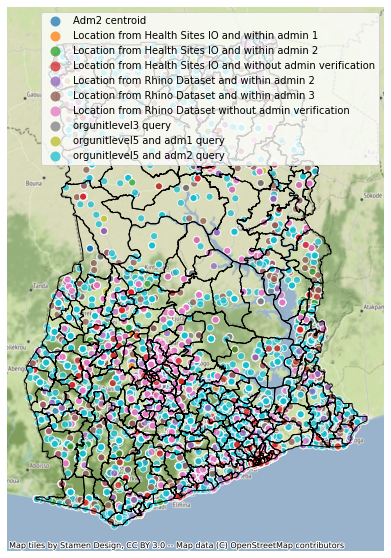

In [609]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
geob2.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from administrative polygons

Join admin data back to results.  
For adm2 features, use spatial join to geob2.  

In [625]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [626]:
results2 = gpd.sjoin(results2, geob2[["shapeName", "shapeID", "geometry"]], how='left', op='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [612]:
results2.rename(
    columns={
        'shapeName':'geob_adm2',
        'shapeID':'geob_adm2_id',
    }, inplace=True)

In [613]:
results2 = gpd.sjoin(results2, geob1[["shapeName", "shapeID", "geometry"]], how='left', op='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [614]:
results2.geob_adm2.isna().sum(), results2.shapeName.isna().sum()

(0, 1)

In [615]:
results2.rename(
    columns={
        'shapeName':'geob_adm1',
        'shapeID':'geob_adm1_id',
        'adm1':'fuzzy_match_adm1',
        'adm2':'fuzzy_match_adm2'
    }, inplace=True)

In [616]:
#results2.to_file(join(output_dir, "GHA_geocoding_1.27.23.json"), driver='GeoJSON', index=True)

In [617]:
results2

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel3_edit,orgunitlevel2_edit,fuzzy_match_adm2,fuzzy_match_adm1,NAME,geocoding_method,longitude,latitude,source,geometry,geob_adm2,geob_adm2_id,geob_adm1,geob_adm1_id
0,Eastern,Abuakwa North,Kukurantumi,Esther Twum Maternity Home,Esther Twum Maternity Home,Kukurantumi,Abuakwa North,NaN,NaN,esther twum maternity home,Location from Health Sites IO and without admi...,-0.185228,5.553747,NaN,POINT (-0.18523 5.55375),Korle Klottey,2480657B35357833911053,Greater Accra,69750345B91661082288531
11,Eastern,Abuakwa North,Tafo,Anyinasin,Anyinasin,Tafo,Abuakwa North,NaN,NaN,anyinasin,Location from Health Sites IO and without admi...,-2.109777,6.600806,NaN,POINT (-2.10978 6.60081),Atwima Mponua,2480657B25907117051030,Ashanti,69750345B92565988218409
12,Eastern,Abuakwa North,Tafo,Asiedukrom,Asiedukrom,Tafo,Abuakwa North,NaN,NaN,asiedukrom,Location from Rhino Dataset without admin veri...,-0.080500,6.008100,GPS,POINT (-0.08050 6.00810),Okere,2480657B18970887366479,Eastern,69750345B54930642926775
14,Eastern,Abuakwa North,Tafo,Mangoase,Mangoase,Tafo,Abuakwa North,NaN,NaN,mangoase,Location from Rhino Dataset without admin veri...,-0.284900,5.952400,GPS,POINT (-0.28490 5.95240),Akwapem North,2480657B49720933786015,Eastern,69750345B54930642926775
15,Eastern,Abuakwa North,Tafo,New Tafo Government Hospital,New Tafo Government Hospital,Tafo,Abuakwa North,NaN,NaN,new tafo,Location from Health Sites IO and without admi...,-0.366038,6.230816,NaN,POINT (-0.36604 6.23082),Abuakwa North,2480657B42374646075926,Eastern,69750345B54930642926775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10559,Ghana,Western North,Suaman,Karlo,Karlo,Suaman,Western North,Suaman,Western North,karlo,Location from Rhino Dataset without admin veri...,-2.546900,10.171400,GPS,POINT (-2.54690 10.17140),Nadowli-kaleo,2480657B27045720373273,Upper West,69750345B23807698276204
10560,Ghana,Western North,Suaman,Karlo,Kwabenakrom,Suaman,Western North,Suaman,Western North,kwabenakrom,orgunitlevel5 and adm2 query,-2.958756,6.148079,NaN,POINT (-2.95876 6.14808),Suaman,2480657B41275879010095,Western North,69750345B35244651716901
10561,Ghana,Western North,Suaman,Karlo,Sui-Ano,Suaman,Western North,Suaman,Western North,sui-ano,Location from Rhino Dataset and within admin 2,-2.772900,6.279200,GPS,POINT (-2.77290 6.27920),Bodi,2480657B1960270363323,Western North,69750345B35244651716901
10562,Ghana,Western North,Suaman,Kwasuo,Kwassuo,Suaman,Western North,Suaman,Western North,kwassuo,Location from Rhino Dataset without admin veri...,-1.447200,6.627700,GPS,POINT (-1.44720 6.62770),Ejisu,2480657B74771824828795,Ashanti,69750345B92565988218409


In [630]:
# FYI saving the results2, the results that were able to be geocoded
print(len(results))
print(len(results2))

10564
9629


In [618]:
#
results2.to_csv(join(output_dir, "GHA_geocoding_1.27.23.csv"))